# Data Import

In [217]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import time

In [218]:

df_transactions_train = pd.read_csv("data/transactions_train.csv")
df_users_data = pd.read_csv("data/users_data.csv")
df_evaluation_features = pd.read_csv("data/evaluation_features.csv")
df_cards_data = pd.read_csv("data/cards_data.csv")

with open("data/mcc_codes.json", "r") as file:
    json_data = json.load(file)
df_mcc_codes = pd.DataFrame(list(json_data.items()), columns=['Code', 'Description'])
df_train_fraud_labels = pd.read_json("data/train_fraud_labels.json", orient='values')


# Data Merging

In [219]:
merged_df = pd.merge(df_transactions_train, df_train_fraud_labels, left_on='transaction_id', right_index=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   transaction_id  210000 non-null  int64  
 1   date            210000 non-null  object 
 2   client_id       210000 non-null  int64  
 3   card_id         210000 non-null  int64  
 4   amount          210000 non-null  object 
 5   use_chip        210000 non-null  object 
 6   merchant_id     210000 non-null  int64  
 7   merchant_city   210000 non-null  object 
 8   merchant_state  184569 non-null  object 
 9   zip             183203 non-null  float64
 10  mcc             210000 non-null  int64  
 11  errors          3273 non-null    object 
 12  target          210000 non-null  object 
dtypes: float64(1), int64(5), object(7)
memory usage: 20.8+ MB


In [220]:
merged_df = pd.merge(merged_df, df_cards_data, left_on=['card_id', 'client_id'], right_on=['id', 'client_id'])
merged_df = pd.merge(merged_df, df_users_data, left_on='client_id', right_on='id')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   transaction_id         210000 non-null  int64  
 1   date                   210000 non-null  object 
 2   client_id              210000 non-null  int64  
 3   card_id                210000 non-null  int64  
 4   amount                 210000 non-null  object 
 5   use_chip               210000 non-null  object 
 6   merchant_id            210000 non-null  int64  
 7   merchant_city          210000 non-null  object 
 8   merchant_state         184569 non-null  object 
 9   zip                    183203 non-null  float64
 10  mcc                    210000 non-null  int64  
 11  errors                 3273 non-null    object 
 12  target                 210000 non-null  object 
 13  id_x                   210000 non-null  int64  
 14  card_brand             210000 non-nu

# Data Exploration

In [221]:
merged_df.describe()

,transaction_id,client_id,card_id,merchant_id,zip,mcc,id_x,card_number,cvv,num_cards_issued,year_pin_last_changed,id_y,current_age,retirement_age,birth_year,birth_month,latitude,longitude,credit_score,num_credit_cards
count,2.100000e+05,210000.000000,210000.000000,210000.000000,183203.000000,210000.000000,210000.000000,2.100000e+05,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000
mean,1.974756e+07,1026.688005,3525.187081,48042.276714,50373.614280,5571.994757,3525.187081,4.847846e+15,500.546695,1.505595,2011.571743,1026.688005,53.932433,66.513119,1965.246371,6.595819,37.365718,-90.939563,712.082238,3.829243
std,1.485640e+06,573.042079,1678.768342,25936.173379,29352.572882,883.626390,1678.768342,1.253260e+15,288.326190,0.515501,2.902563,573.042079,15.931667,3.531375,15.927236,3.612052,5.093062,16.289434,67.621151,1.556342
min,1.717259e+07,0.000000,0.000000,22.000000,1028.000000,1711.000000,0.000000,3.021287e+14,0.000000,1.000000,2002.000000,0.000000,23.000000,53.000000,1918.000000,1.000000,21.300000,-158.180000,488.000000,1.000000
25%,1.846539e+07,556.000000,2443.000000,25887.000000,28215.000000,5300.000000,2443.000000,4.536094e+15,255.000000,1.000000,2010.000000,556.000000,42.000000,65.000000,1956.000000,3.000000,33.920000,-97.220000,683.000000,3.000000
50%,1.974602e+07,1073.000000,3675.000000,46284.000000,46260.000000,5499.000000,3675.000000,5.112842e+15,512.000000,1.000000,2011.000000,1073.000000,52.000000,66.000000,1967.000000,7.000000,38.410000,-85.740000,717.000000,4.000000
75%,2.103520e+07,1520.000000,4949.000000,68751.000000,77086.000000,5813.000000,4949.000000,5.563288e+15,745.000000,2.000000,2014.000000,1520.000000,63.000000,68.000000,1977.000000,10.000000,41.020000,-79.540000,756.000000,5.000000
max,2.232644e+07,1997.000000,6138.000000,100340.000000,99928.000000,9402.000000,6138.000000,6.987062e+15,998.000000,3.000000,2020.000000,1997.000000,101.000000,78.000000,1996.000000,12.000000,48.280000,-68.670000,850.000000,9.000000


In [222]:
merged_df.isnull().sum()

transaction_id                0
date                          0
client_id                     0
card_id                       0
amount                        0
use_chip                      0
merchant_id                   0
merchant_city                 0
merchant_state            25431
zip                       26797
mcc                           0
errors                   206727
target                        0
id_x                          0
card_brand                    0
card_type                     0
card_number                   0
expires                       0
cvv                           0
has_chip                      0
num_cards_issued              0
credit_limit                  0
acct_open_date                0
year_pin_last_changed         0
card_on_dark_web              0
id_y                          0
current_age                   0
retirement_age                0
birth_year                    0
birth_month                   0
gender                        0
address 

In [223]:
for col in merged_df.columns[merged_df.isnull().any()]:
    print(f"Unique values in '{col}':")
    display(merged_df[col].unique())
    print("\n")

Unique values in 'merchant_state':


array(['MO', 'IA', 'CA', 'NY', 'FL', 'VT', 'WI', 'NJ', 'TN', 'NE', 'OK',
       'Mexico', nan, 'MA', 'SC', 'MN', 'TX', 'OH', 'CT', 'AR', 'HI',
       'MI', 'NM', 'NC', 'MD', 'PA', 'IN', 'OR', 'AL', 'ME', 'UT', 'AZ',
       'NV', 'GA', 'CO', 'KS', 'WA', 'SD', 'WV', 'DE', 'KY', 'IL', 'VA',
       'NH', 'Norway', 'LA', 'ID', 'MT', 'MS', 'ND', 'RI', 'Italy',
       'France', 'DC', 'Taiwan', 'AK', 'South Korea', 'India', 'Hungary',
       'WY', 'Canada', 'Hong Kong', 'China', 'The Bahamas', 'Germany',
       'United Kingdom', 'Jamaica', 'Australia', 'Ireland', 'Philippines',
       'South Africa', 'Netherlands', 'Peru', 'Russia', 'Colombia',
       'Thailand', 'Dominican Republic', 'Costa Rica', 'Japan',
       'Saudi Arabia', 'Vatican City', 'Iran', 'Lithuania', 'Brazil',
       'Myanmar (Burma)', 'Ghana', 'Finland', 'Austria', 'Portugal',
       'Malta', 'Slovenia', 'Macedonia', 'Sweden', 'Israel', 'Luxembourg',
       'New Zealand', "Cote d'Ivoire", 'Switzerland', 'Malaysia',
       'Ukr



Unique values in 'zip':


array([63010., 50313., 92630., ..., 92596., 17408.,  1850.],
      shape=(10264,))



Unique values in 'errors':


array([nan, 'Technical Glitch', 'Insufficient Balance', 'Bad PIN',
       'Bad Card Number', 'Bad CVV', 'Bad Expiration',
       'Bad Card Number,Bad Expiration', 'Bad Zipcode',
       'Bad Expiration,Insufficient Balance',
       'Insufficient Balance,Technical Glitch',
       'Bad Card Number,Insufficient Balance',
       'Bad PIN,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Bad Expiration,Technical Glitch', 'Bad Expiration,Bad CVV',
       'Bad CVV,Insufficient Balance'], dtype=object)

In [224]:
merged_df['target'].value_counts(normalize=True)

target
No     0.9985
Yes    0.0015
Name: proportion, dtype: float64

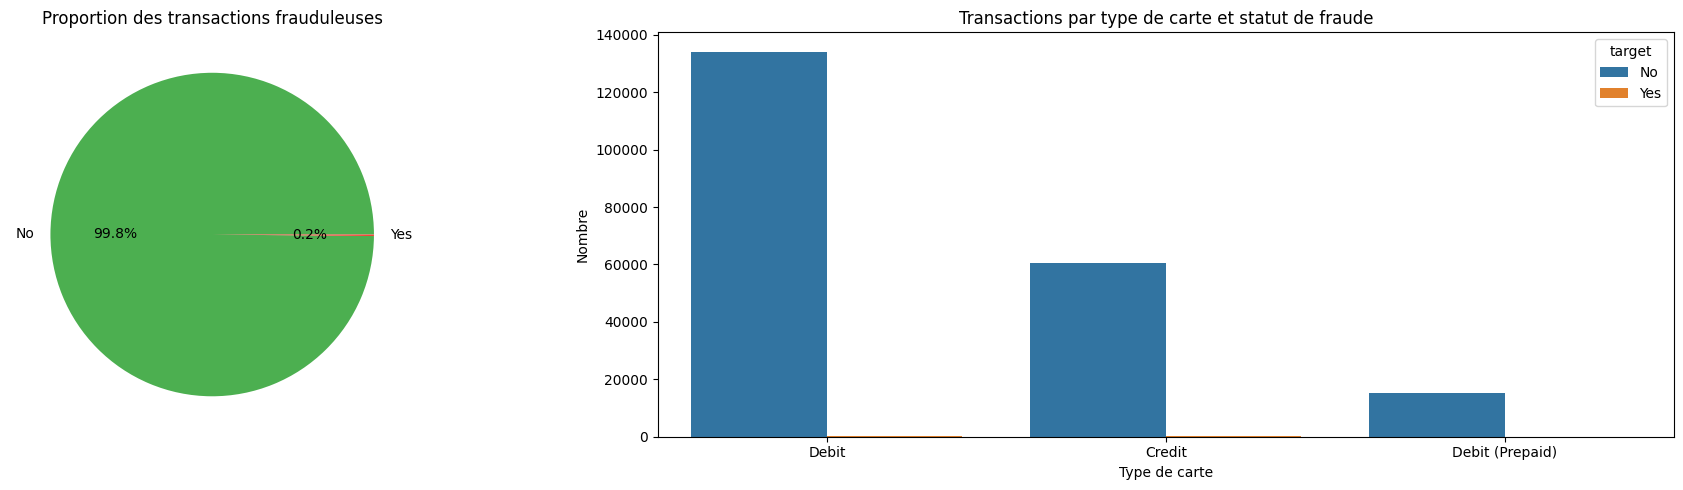

In [225]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

merged_df['target'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['#4CAF50','#F44336'],
    ax=axes[0]
)
axes[0].set_title("Proportion des transactions frauduleuses")
axes[0].set_ylabel("")

sns.countplot(data=merged_df, x='card_type', hue='target', ax=axes[1])
axes[1].set_title("Transactions par type de carte et statut de fraude")
axes[1].set_xlabel("Type de carte")
axes[1].set_ylabel("Nombre")

plt.tight_layout()
plt.show()


# Data cleaning

In [226]:

def data_cleaning_pipeline(df):
    financial_cols = ['amount', 'credit_limit', 'yearly_income']
    for col in financial_cols:
        if col in df.columns:
            # Nettoyage et conversion en float
            df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)
            print(f"  ✅ Colonne '{col}' nettoyée et convertie en float.")
        else:
            print(f"  ⚠️ Colonne '{col}' non trouvée dans le DataFrame, ignorée.")
    date_col = 'date'
    if date_col in df.columns:
        # Conversion en datetime (avec 'errors="coerce"' pour gérer les erreurs)
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        print(f"  ✅ Colonne '{date_col}' convertie en datetime.")
    else:
        print(f"  ⚠️ Colonne '{date_col}' non trouvée dans le DataFrame, ignorée.")
    
    df['merchant_state'] = df['merchant_state'].fillna('online')


    # =============================================================================


    ds = pd.to_datetime(df['date'], errors='coerce')   
    df['annee'] = ds.dt.year
    df['mois'] = ds.dt.month
    df['jour'] = ds.dt.day
    df['heure'] = ds.dt.hour
    
    df['jour_de_la_semaine_indice'] = ds.dt.dayofweek
    
    mapping_jours_fr = {
        0: 'Lundi', 1: 'Mardi', 2: 'Mercredi',
        3: 'Jeudi', 4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'
    }
    df['jour_de_la_semaine_nom'] = df['jour_de_la_semaine_indice'].map(mapping_jours_fr)
    df['est_weekend'] = (ds.dt.dayofweek >= 5).astype(int)
    
    df.drop(columns=['date'], inplace=True)


    # =============================================================================

    cols_to_convert = ['use_chip', 'merchant_city', 'merchant_state', 'card_brand', 
                       'card_type', 'address', 'jour_de_la_semaine_nom']
    
    for col in cols_to_convert:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = df[col].astype('string')

    # =============================================================================

    def encode_binary_columns(df, columns):
        mappings = {}
        for col in columns:
            if col in df.columns:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col])
                mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
        return df, mappings

    binary_cols = ['target', 'has_chip', 'card_on_dark_web', 'gender']
    df, enc_map = encode_binary_columns(df, binary_cols)

    # =============================================================================

    def split_month_year_multi(df, date_columns):
        for col in date_columns:
            if col not in df.columns:
                continue
            
            split_data = df[col].astype(str).str.split('/', expand=True)
            df[f"{col}_mois"] = pd.to_numeric(split_data[0], errors='coerce').astype('Int64')
            df[f"{col}_annees"] = pd.to_numeric(split_data[1], errors='coerce').astype('Int64')
        
        df.drop(columns=date_columns, inplace=True, errors='ignore')
        return df

    cols_to_split = ['expires', 'acct_open_date']
    df = split_month_year_multi(df, cols_to_split)

    # =============================================================================

    def clean_dollar_columns(df, columns):
        for col in columns:
            if col in df.columns:
                df[col] = (
                    df[col].astype(str)
                    .str.replace('$', '', regex=False)
                    .str.replace(',', '', regex=False)
                    .str.strip()
                )
                df[col] = pd.to_numeric(df[col], errors='coerce')
        return df

    dollar_cols = ['per_capita_income', 'total_debt']
    df = clean_dollar_columns(df, dollar_cols)

    # =============================================================================

    colonnes_a_supprimer = ['transaction_id', 'address', 'zip', 'errors']
    df = df.drop(columns=[c for c in colonnes_a_supprimer if c in df.columns], axis=1)

    print("✅ Pipeline preprocessing terminé ✅")
    return df


<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
/var/folders/87/44q727sx1wzdm8x65p5jb4z40000gn/T/ipykernel_41204/2648403067.py:6: SyntaxWarning: invalid escape sequence '\$'
  df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)


# Data Preprocessing

In [227]:
def data_preprocessing_pipeline(df):

    colonnes_haute_cardinalite = ['merchant_city', 'card_number']
    df = df.drop(columns=colonnes_haute_cardinalite, errors='ignore')

    # =============================================================================

    colonnes_onehot = ['use_chip', 'card_brand', 'card_type']
    colonnes_label = ['merchant_state', 'jour_de_la_semaine_nom']

    onehot_encoders = {}
    for col in colonnes_onehot:
        if col in df.columns:
            # Créer le OneHotEncoder
            ohe = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' pour éviter la multicolinéarité
            
            # Encoder la colonne
            encoded = ohe.fit_transform(df[[col]].astype(str))
            
            # Créer les noms des nouvelles colonnes
            feature_names = [f"{col}_{cat}" for cat in ohe.categories_[0][1:]]  # On skip la première catégorie (drop='first')
            
            # Créer un DataFrame avec les colonnes encodées
            encoded_df = pd.DataFrame(encoded, columns=feature_names, index=df.index)
            
            # Ajouter les nouvelles colonnes et supprimer l'ancienne
            df = pd.concat([df, encoded_df], axis=1)
            df = df.drop(columns=[col])
            
            onehot_encoders[col] = ohe

    # 🔹 LabelEncoder pour merchant_state, jour_de_la_semaine_nom
    label_encoders = {}
    for col in colonnes_label:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le

    # =============================================================================

    if 'target' not in df.columns:
        print("❌ ERREUR: La colonne 'target' est absente. L'analyse de corrélation est ignorée.")
        
        # Définition par défaut des colonnes à supprimer (uniquement les identifiants)
        colonnes_a_supprimer_final = ['id_x', 'id_y', 'card_id', 'client_id', 'birth_year', 'credit_limit', 'card_on_dark_web', 'current_age']
        colonnes_a_supprimer_final = [col for col in colonnes_a_supprimer_final if col in df.columns]

    else:
        print("✅ Colonne 'target' trouvée. Calcul des corrélations...")
        
        # Calcul de la corrélation (numeric_only=True pour éviter les erreurs avec les types non numériques)
        correlation_with_target = df.corr(numeric_only=True)['target'].sort_values(ascending=False)
        
        # Affichage du graphique de corrélation
        plot_data = correlation_with_target.drop('target', errors='ignore')
        if not plot_data.empty:
            fig, ax = plt.subplots(figsize=(10, 12))
            plot_data.plot(kind='barh', ax=ax, color='steelblue')
            ax.set_title("Corrélation des features avec 'target'", fontsize=16, fontweight='bold')
            ax.set_xlabel("Coefficient de corrélation")
            ax.set_ylabel("Features")
            ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
            plt.tight_layout()
            plt.show()

        # Identification des features à faible corrélation
        seuil_correlation = 0.005
        faibles_correlations = correlation_with_target[
            (correlation_with_target.abs() < seuil_correlation) & (correlation_with_target.index != 'target')
        ]

        # Combinaison des colonnes à supprimer
        colonnes_a_supprimer_faible_corr = list(faibles_correlations.index)
        colonnes_a_supprimer_ids = ['id_x', 'id_y', 'card_id', 'client_id', 'birth_year', 'credit_limit', 'card_on_dark_web', 'current_age']
        
        colonnes_a_supprimer_final = colonnes_a_supprimer_faible_corr + colonnes_a_supprimer_ids
        colonnes_a_supprimer_final = [col for col in colonnes_a_supprimer_final if col in df.columns]
        
        print(f"  -> {len(colonnes_a_supprimer_final)} colonnes identifiées pour suppression (faible corrélation ou IDs).")


    # --- 4. Suppression finale des colonnes inutiles ---
    if colonnes_a_supprimer_final:
        df = df.drop(columns=colonnes_a_supprimer_final, errors='ignore')
        print(f"\n🗑️ Suppression finale des colonnes : {len(colonnes_a_supprimer_final)} features supprimées.")
    else:
        print("\n🗑️ Aucune colonne supplémentaire à supprimer (excepté la haute cardinalité initiale).")
    
    print(f"\n✅ Pipeline terminé. Shape final du DataFrame : {df.shape}")

    return df

# Data Sampling

In [228]:
def data_undersampling_pipeline(df):
    X = df.drop('target', axis=1)
    y = df['target']
    rus = RandomUnderSampler(random_state=42)
    X_undersampled, y_undersampled = rus.fit_resample(X, y)

    # Créer le DataFrame undersampled
    df_undersampled = pd.concat([X_undersampled, y_undersampled], axis=1)

    return df_undersampled

In [229]:
def data_oversampling_pipeline(df):
    X = df.drop('target', axis=1)
    y = df['target']
    smote = SMOTE(random_state=42)
    X_oversampled, y_oversampled = smote.fit_resample(X, y)

    # Créer le DataFrame oversampled
    df_oversampled = pd.concat([X_oversampled, y_oversampled], axis=1)

    return df_oversampled

In [230]:
def data_hybrid_pipeline(df):
    X = df.drop('target', axis=1)
    y = df['target']
    smt = SMOTETomek(random_state=42)
    X_hybrid, y_hybrid = smt.fit_resample(X, y)

    # Créer le DataFrame hybrid
    df_hybrid = pd.concat([X_hybrid, y_hybrid], axis=1)

    return df_hybrid

In [231]:
def data_viz_sampling_pipeline(df, df_undersampling, df_oversampling, df_hybrid):
    y = df['target']
    y_undersampled = df_undersampling['target']
    y_oversampled = df_oversampling['target']
    y_hybrid = df_hybrid['target']

    # 1️⃣4️⃣ Comparaison visuelle des distributions
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Dataset original
    axes[0, 0].bar(['Non-Fraude', 'Fraude'], y.value_counts().sort_index().values, color=['#4CAF50', '#F44336'])
    axes[0, 0].set_title('Dataset Original', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Nombre de transactions')
    axes[0, 0].text(0, y.value_counts()[0] + 5000, f'{y.value_counts()[0]:,}', ha='center', fontsize=11)
    axes[0, 0].text(1, y.value_counts()[1] + 5000, f'{y.value_counts()[1]:,}', ha='center', fontsize=11)

    # Undersampling
    axes[0, 1].bar(['Non-Fraude', 'Fraude'], y_undersampled.value_counts().sort_index().values, color=['#4CAF50', '#F44336'])
    axes[0, 1].set_title('Undersampling', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Nombre de transactions')
    axes[0, 1].text(0, y_undersampled.value_counts()[0] + 20, f'{y_undersampled.value_counts()[0]:,}', ha='center', fontsize=11)
    axes[0, 1].text(1, y_undersampled.value_counts()[1] + 20, f'{y_undersampled.value_counts()[1]:,}', ha='center', fontsize=11)

    # Oversampling (SMOTE)
    axes[1, 0].bar(['Non-Fraude', 'Fraude'], y_oversampled.value_counts().sort_index().values, color=['#4CAF50', '#F44336'])
    axes[1, 0].set_title('Oversampling (SMOTE)', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Nombre de transactions')
    axes[1, 0].text(0, y_oversampled.value_counts()[0] + 5000, f'{y_oversampled.value_counts()[0]:,}', ha='center', fontsize=11)
    axes[1, 0].text(1, y_oversampled.value_counts()[1] + 5000, f'{y_oversampled.value_counts()[1]:,}', ha='center', fontsize=11)

    # Hybrid (SMOTE + Tomek)
    axes[1, 1].bar(['Non-Fraude', 'Fraude'], y_hybrid.value_counts().sort_index().values, color=['#4CAF50', '#F44336'])
    axes[1, 1].set_title('Hybrid Sampling (SMOTE + Tomek)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Nombre de transactions')
    axes[1, 1].text(0, y_hybrid.value_counts()[0] + 5000, f'{y_hybrid.value_counts()[0]:,}', ha='center', fontsize=11)
    axes[1, 1].text(1, y_hybrid.value_counts()[1] + 5000, f'{y_hybrid.value_counts()[1]:,}', ha='center', fontsize=11)

    plt.tight_layout()
    plt.show()

    # 1️⃣5️⃣ Comparaison sous forme de tableau récapitulatif
    summary_data = {
        'Stratégie': ['Original', 'Undersampling', 'Oversampling (SMOTE)', 'Hybrid (SMOTE + Tomek)'],
        'Taille totale': [len(y), len(y_undersampled), len(y_oversampled), len(y_hybrid)],
        'Non-Fraude (0)': [y.value_counts()[0], y_undersampled.value_counts()[0], 
                        y_oversampled.value_counts()[0], y_hybrid.value_counts()[0]],
        'Fraude (1)': [y.value_counts()[1], y_undersampled.value_counts()[1], 
                    y_oversampled.value_counts()[1], y_hybrid.value_counts()[1]],
        'Ratio (0:1)': [
            f"{y.value_counts()[0]/y.value_counts()[1]:.2f}:1",
            f"{y_undersampled.value_counts()[0]/y_undersampled.value_counts()[1]:.2f}:1",
            f"{y_oversampled.value_counts()[0]/y_oversampled.value_counts()[1]:.2f}:1",
            f"{y_hybrid.value_counts()[0]/y_hybrid.value_counts()[1]:.2f}:1"
        ]
    }

    df_summary = pd.DataFrame(summary_data)
    print("📊 Récapitulatif des stratégies de sampling :\n")
    print(df_summary.to_string(index=False))

    # 1️⃣6️⃣ Visualisation en camembert pour chaque stratégie
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    datasets = [
        (y, 'Original'),
        (y_undersampled, 'Undersampling'),
        (y_oversampled, 'Oversampling (SMOTE)'),
        (y_hybrid, 'Hybrid (SMOTE + Tomek)')
    ]

    for idx, (data, title) in enumerate(datasets):
        counts = data.value_counts()
        axes[idx].pie(counts, labels=['Non-Fraude', 'Fraude'], autopct='%1.1f%%', 
                    colors=['#4CAF50', '#F44336'], startangle=90)
        axes[idx].set_title(f'{title}\n({len(data):,} transactions)', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    corr_matrix = df_undersampling.corr(numeric_only=True)

    # Affichage avec une heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
    plt.title("Matrice de corrélation - df_undersampled")
    plt.show()

    dataframes = {
        'df': df,
        'df_undersampling': df_undersampling,
        'df_oversampling': df_oversampling,
        'df_hybrid': df_hybrid
    }

    # 1. Créer la figure avec 1 ligne et 4 colonnes
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    plt.subplots_adjust(wspace=0.3) # Ajuster l'espacement entre les sous-graphiques

    # 2. Itérer pour calculer et tracer chaque matrice
    for i, (name, dataframe) in enumerate(dataframes.items()):
        # Calculer la matrice de corrélation
        corr_matrix = dataframe.corr()

        # Créer la heatmap sur l'axe correspondant
        sns.heatmap(
            corr_matrix,
            ax=axes[i],
            annot=True,              # Afficher les valeurs de corrélation
            fmt=".2f",               # Format des nombres (2 décimales)
            cmap='coolwarm',         # Palette de couleurs (rouge/bleu)
            cbar=True,               # Afficher la barre de couleur
            vmin=-1, vmax=1          # Fixer l'échelle de -1 à 1
        )

        # Définir le titre
        axes[i].set_title(f'Matrice de Corrélation: {name}', fontsize=10)
        # Rotation pour une meilleure lisibilité des étiquettes d'axe
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=0)

    # Titre général
    plt.suptitle("Comparaison des Matrices de Corrélation", fontsize=14, y=1.02)
    plt.tight_layout()


# Models training

In [232]:
def train_and_evaluate(model, X_train_split_model, y_train_split_model, X_val_split_model, y_val_split_model, model_name, dataset_name):
    """
    Entraîne un modèle et retourne les métriques de performance
    """
    print(f"\n🔄 Entraînement de {model_name} sur {dataset_name}...")
    
    start_time = time.time()
    model.fit(X_train_split_model, y_train_split_model)
    train_time = time.time() - start_time
    
    # Prédictions
    y_pred = model.predict(X_val_split_model)
    y_pred_proba = model.predict_proba(X_val_split_model)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    # Calcul des métriques
    metrics = {
        'Model': model_name,
        'Dataset': dataset_name,
        'Accuracy': accuracy_score(y_val_split_model, y_pred),
        'Precision': precision_score(y_val_split_model, y_pred, zero_division=0),
        'Recall': recall_score(y_val_split_model, y_pred, zero_division=0),
        'F1-Score': f1_score(y_val_split_model, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_val_split_model, y_pred_proba),
        'Train Time (s)': round(train_time, 2)
    }
    
    print(f"✅ {model_name} terminé en {train_time:.2f}s")
    
    return metrics, model, y_pred, y_pred_proba

# Visualisation

In [233]:
def data_visualisation_pipeline(df_results, trained_models, y_val_splited):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

    # Vérification de la structure du DataFrame
    if 'Dataset' not in df_results.columns or 'Model' not in df_results.columns:
        print("❌ Erreur: Le DataFrame 'df_results' doit contenir les colonnes 'Dataset' et 'Model'.")
        return

    # ========================================================================
    # 0️⃣ Identification du meilleur modèle
    # ========================================================================
    df_filtered_for_best = df_results[df_results['Dataset'].isin(['Oversampled', 'Hybrid', 'IBM'])].copy()
    df_filtered_for_best = df_filtered_for_best.sort_values('Recall', ascending=False)

    if df_filtered_for_best.empty:
        print("\n⚠️ Aucun modèle trouvé dans les datasets 'Oversampled' ou 'Hybrid'.")
        best_model_row = df_results.sort_values('Recall', ascending=False).iloc[0]
    else:
        best_model_row = df_filtered_for_best.iloc[0]

    # ========================================================================
    # 1️⃣ Affichage global des résultats
    # ========================================================================
    print("="*80)
    print("📊 RÉSULTATS DE TOUS LES MODÈLES (Triés par Recall) :\n")
    print(df_results.sort_values('Recall', ascending=False).to_string(index=False))

    print(f"\n{'='*80}")
    print(f"🏆 MEILLEUR MODÈLE (sur Oversampled/Hybrid/IBM) : {best_model_row['Model']} sur {best_model_row['Dataset']}")
    print(f"{'='*80}")
    print(f"  F1-Score : {best_model_row['F1-Score']:.4f}")
    print(f"  ROC-AUC  : {best_model_row['ROC-AUC']:.4f}")
    print(f"  Recall   : {best_model_row['Recall']:.4f}")
    print(f"  Precision: {best_model_row['Precision']:.4f}")

    # ========================================================================
    # 2️⃣ Graphiques de comparaison des performances
    # ========================================================================
    print("\n\n" + "="*80)
    print("📈 GRAPHIQUES DE COMPARAISON DES PERFORMANCES")
    print("="*80)

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    metrics_to_plot = ['F1-Score', 'ROC-AUC', 'Recall', 'Precision']

    dataset_colors = {
        'Original': '#4CAF50',
        'Undersampled': '#FF9800',
        'Oversampled': '#2196F3',
        'Hybrid': '#9C27B0',
        'IBM': '#00BCD4'
    }

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        pivot_data = df_results.pivot(index='Model', columns='Dataset', values=metric)
        colors = [dataset_colors.get(col, 'gray') for col in pivot_data.columns]

        pivot_data.plot(kind='bar', ax=ax, color=colors, width=0.8)
        ax.set_title(f'Comparaison - {metric}', fontsize=14, fontweight='bold')
        ax.set_ylabel(metric)
        ax.set_xlabel('Modèle')
        ax.legend(title='Dataset', loc='best')
        ax.grid(axis='y', alpha=0.3)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    # ========================================================================
    # 3️⃣ Heatmap des Recall
    # ========================================================================
    fig, ax = plt.subplots(figsize=(14, 8))
    heatmap_data = df_results.pivot(index='Model', columns='Dataset', values='Recall')

    sns.heatmap(
        heatmap_data, annot=True, fmt='.4f', cmap='viridis',
        cbar_kws={'label': 'Recall'}, linewidths=1, linecolor='white', ax=ax
    )
    ax.set_title('Heatmap des Recall par Modèle et Dataset', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # ========================================================================
    # 4️⃣ Top 5 des meilleures performances (Oversampled & Hybrid)
    # ========================================================================
    fig, ax = plt.subplots(figsize=(12, 6))
    top_5 = df_filtered_for_best.head(5).copy()
    top_5['Model_Dataset'] = top_5['Model'] + '\n(' + top_5['Dataset'] + ')'

    x = range(len(top_5))
    width = 0.2

    ax.bar([i - width*1.5 for i in x], top_5['F1-Score'], width, label='F1-Score', color='#2196F3')
    ax.bar([i - width*0.5 for i in x], top_5['Precision'], width, label='Precision', color='#4CAF50')
    ax.bar([i + width*0.5 for i in x], top_5['Recall'], width, label='Recall', color='#FF9800')
    ax.bar([i + width*1.5 for i in x], top_5['ROC-AUC'], width, label='ROC-AUC', color='#9C27B0')

    ax.set_xlabel('Modèle (Dataset)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Top 5 des Meilleures Performances (Oversampled & Hybrid)', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(top_5['Model_Dataset'], rotation=0, fontsize=10)
    ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.05])
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

    print(f"\n📊 Nombre de modèles affichés: {len(top_5)}")
    print("Datasets inclus: Oversampled, Hybrid")

    # ========================================================================
    # 5️⃣ Matrice de confusion et courbe ROC du meilleur modèle
    # ========================================================================
    best_model_key = f"{best_model_row['Model']}_{best_model_row['Dataset']}"
    best_predictions = trained_models[best_model_key]['predictions']
    best_probabilities_raw = trained_models[best_model_key]['probabilities']

    # Vérification dimension des probabilités
    if hasattr(best_probabilities_raw, 'ndim') and best_probabilities_raw.ndim == 2 and best_probabilities_raw.shape[1] > 1:
        best_probabilities = best_probabilities_raw[:, 1]
    else:
        best_probabilities = best_probabilities_raw

    y_val = y_val_splited.get(best_model_row['Dataset'])
    if y_val is None:
        print(f"\n❌ Erreur: y_val introuvable pour {best_model_row['Dataset']}")
        return

    print("\n\n" + "="*80)
    print(f"🔬 ANALYSE DU MEILLEUR MODÈLE : {best_model_row['Model']} sur {best_model_row['Dataset']}")
    print("="*80)

    # Matrice de confusion
    cm = confusion_matrix(y_val, best_predictions)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Fraude (0)', 'Fraude (1)'],
                yticklabels=['Non-Fraude (0)', 'Fraude (1)'], ax=ax)
    ax.set_title(f'Matrice de Confusion - {best_model_row["Model"]} ({best_model_row["Dataset"]})', fontsize=14, fontweight='bold')
    ax.set_ylabel('Vraie Classe')
    ax.set_xlabel('Classe Prédite')
    plt.tight_layout()
    plt.show()

    print("\n📊 Rapport de classification détaillé :")
    print(classification_report(y_val, best_predictions, target_names=['Non-Fraude', 'Fraude']))

    # Courbe ROC
    fpr, tpr, thresholds = roc_curve(y_val, best_probabilities)
    roc_auc = auc(fpr, tpr)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Taux de Faux Positifs (FPR)')
    ax.set_ylabel('Taux de Vrais Positifs (TPR - Recall)')
    ax.set_title(f'Courbe ROC - {best_model_row["Model"]} ({best_model_row["Dataset"]})', fontsize=14, fontweight='bold')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Main

## Cleaning & Preprocessing

  ✅ Colonne 'amount' nettoyée et convertie en float.
  ✅ Colonne 'credit_limit' nettoyée et convertie en float.
  ✅ Colonne 'yearly_income' nettoyée et convertie en float.
  ✅ Colonne 'date' convertie en datetime.
✅ Pipeline preprocessing terminé ✅
✅ Colonne 'target' trouvée. Calcul des corrélations...
✅ Pipeline preprocessing terminé ✅
✅ Colonne 'target' trouvée. Calcul des corrélations...


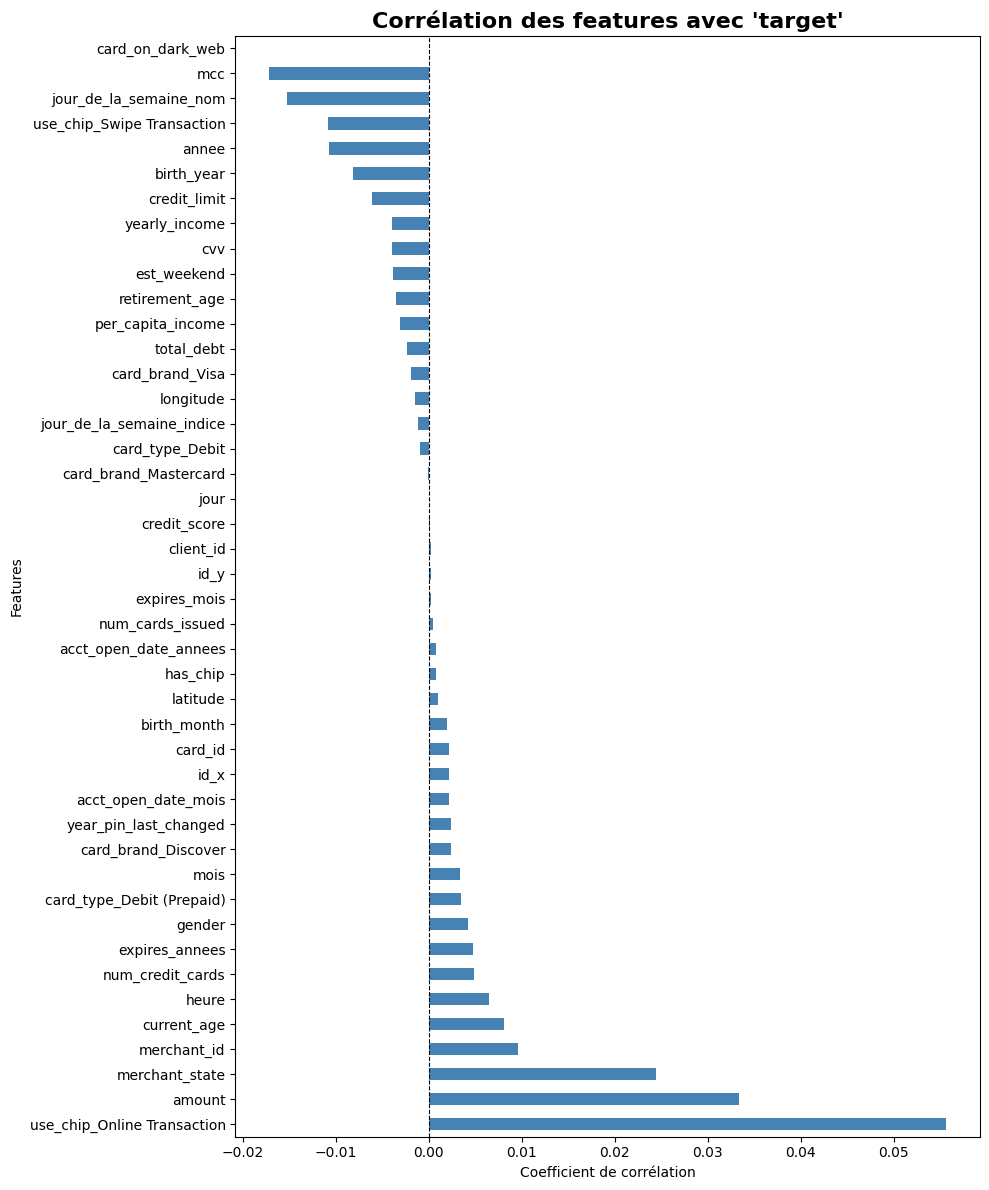

  -> 39 colonnes identifiées pour suppression (faible corrélation ou IDs).

🗑️ Suppression finale des colonnes : 39 features supprimées.

✅ Pipeline terminé. Shape final du DataFrame : (210000, 10)


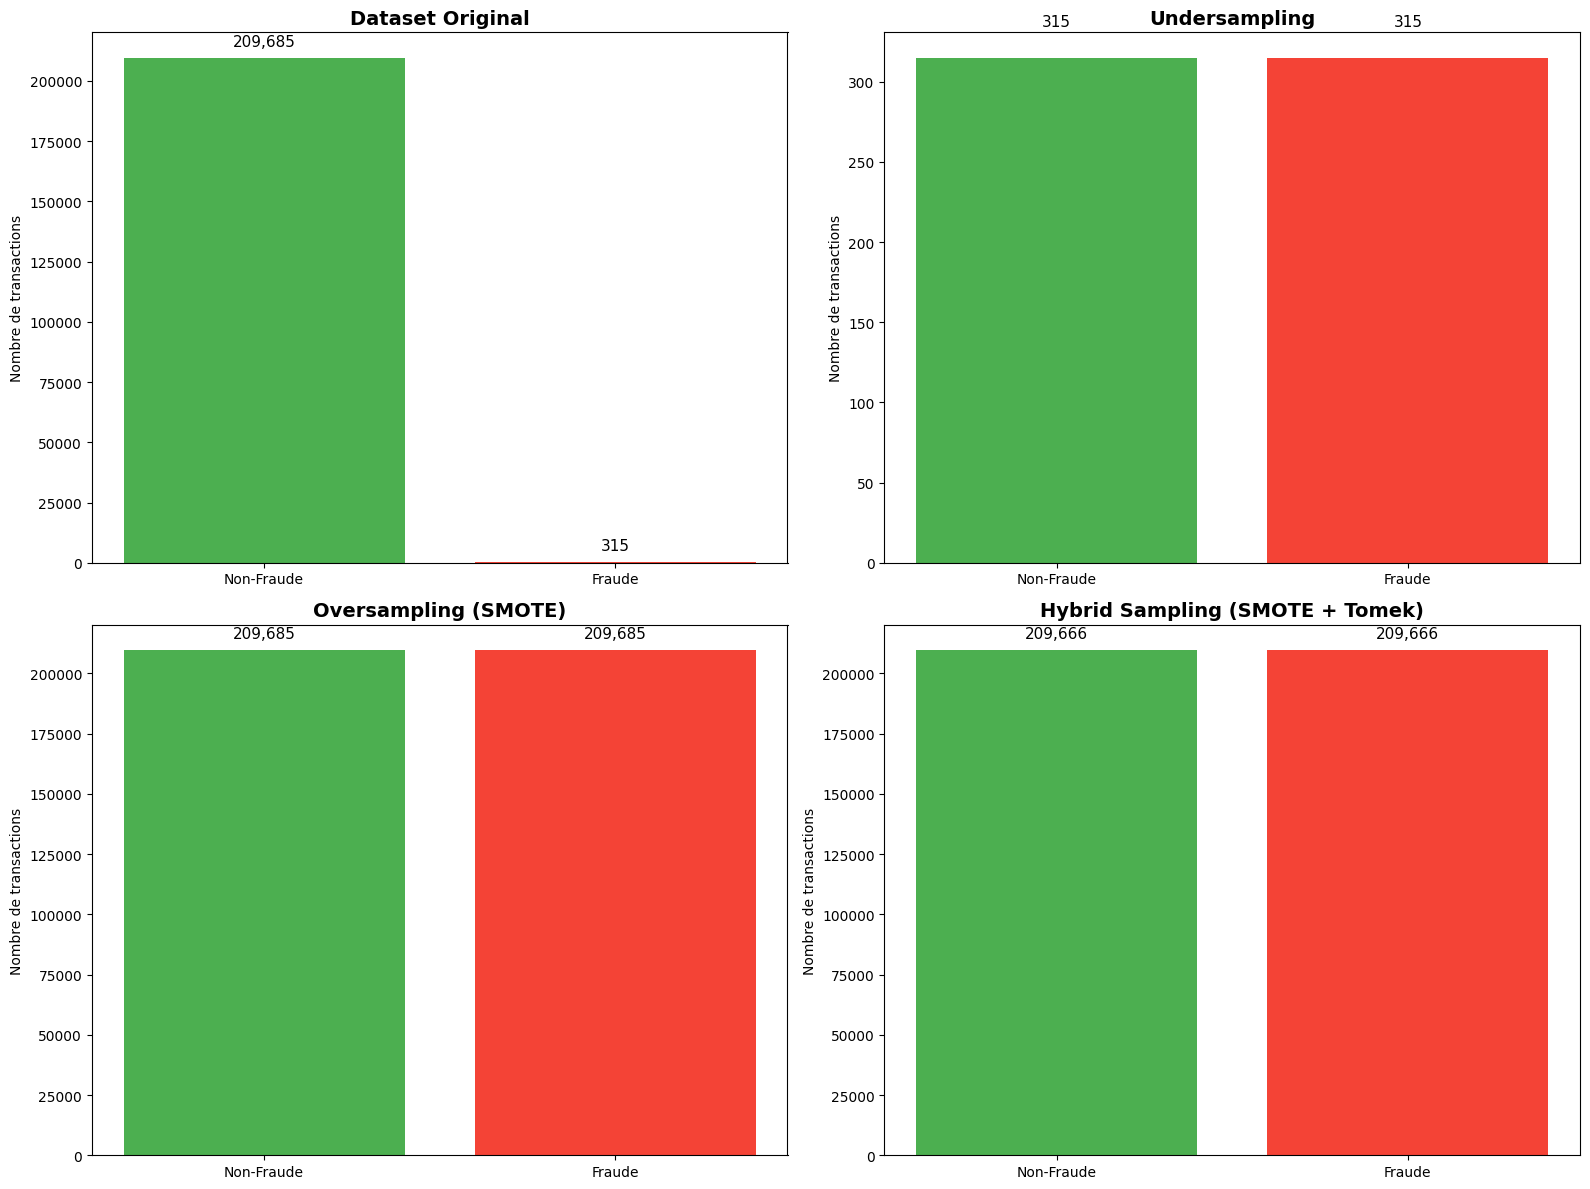

📊 Récapitulatif des stratégies de sampling :

             Stratégie  Taille totale  Non-Fraude (0)  Fraude (1) Ratio (0:1)
              Original         210000          209685         315    665.67:1
         Undersampling            630             315         315      1.00:1
  Oversampling (SMOTE)         419370          209685      209685      1.00:1
Hybrid (SMOTE + Tomek)         419332          209666      209666      1.00:1


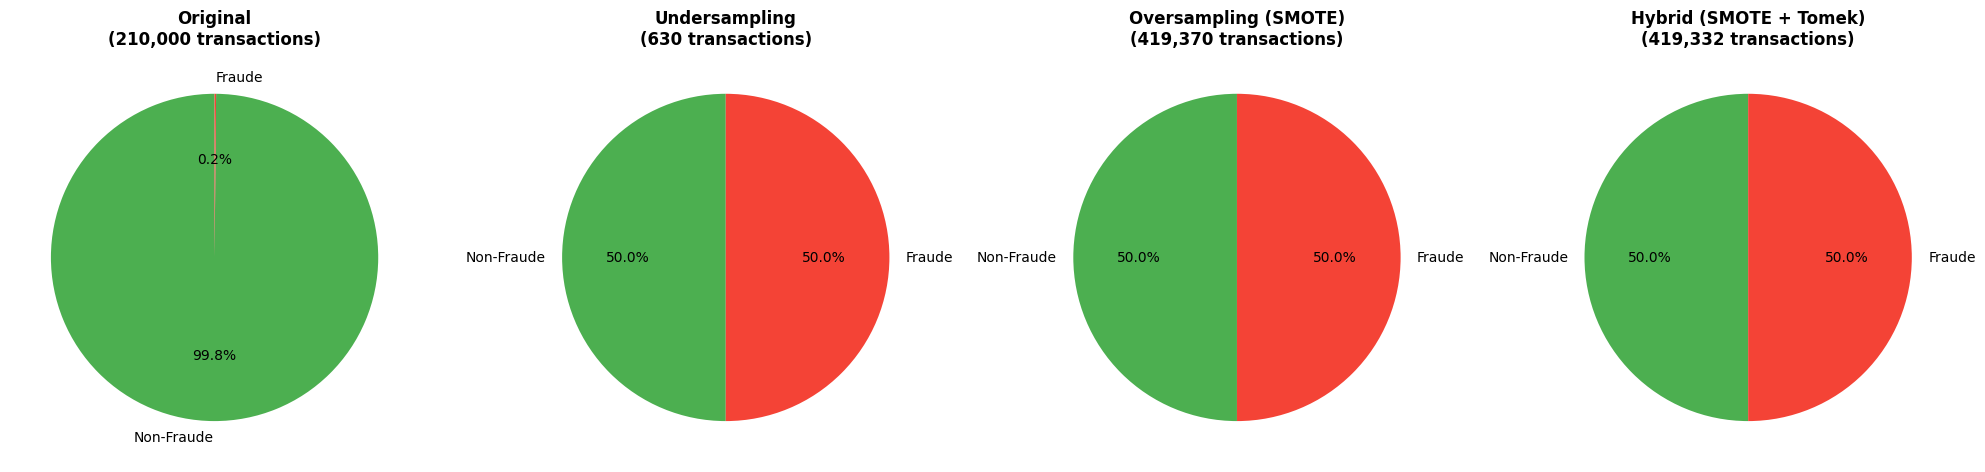

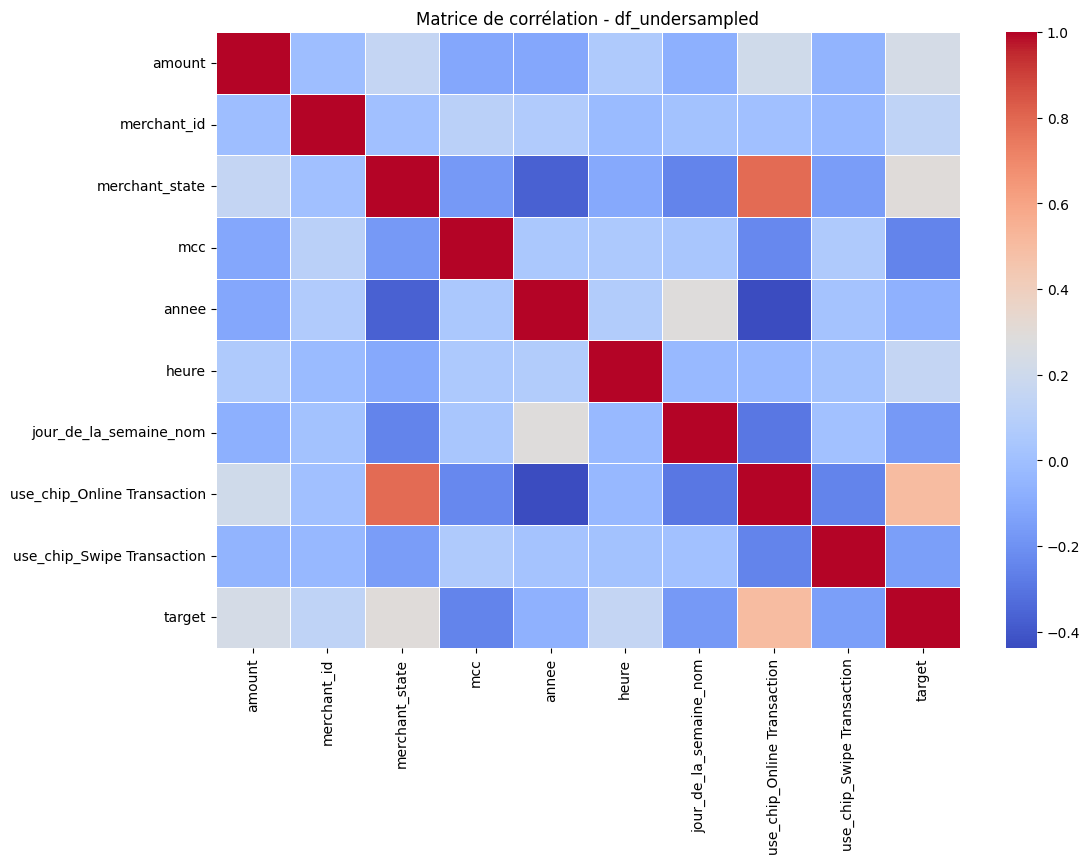

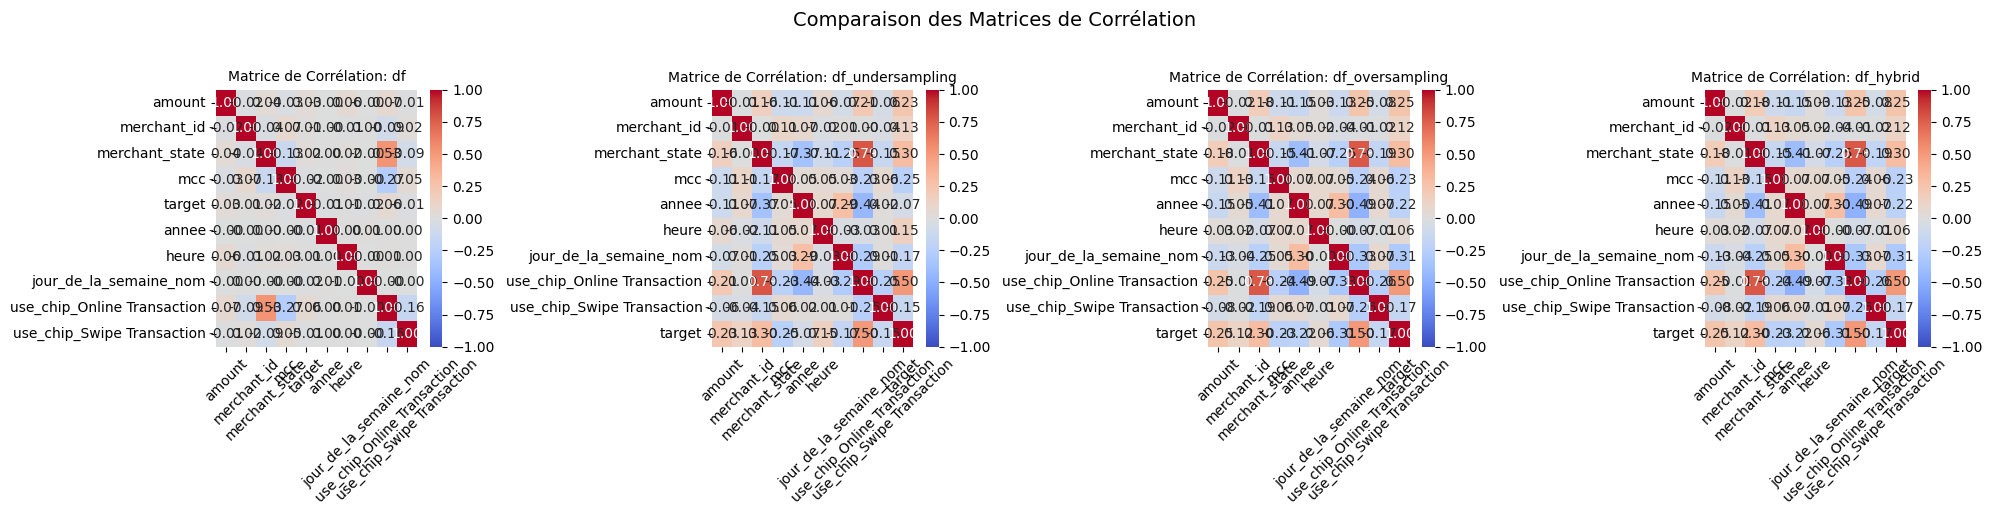

In [234]:
merged_df = data_cleaning_pipeline(merged_df)
merged_df = data_preprocessing_pipeline(merged_df)
df_undersampling = data_undersampling_pipeline(merged_df)
df_oversampling = data_oversampling_pipeline(merged_df)
df_hybrid = data_hybrid_pipeline(merged_df)
data_viz_sampling_pipeline(merged_df, df_undersampling, df_oversampling, df_hybrid)

## Training

In [235]:
df_fraud_ibm = pd.read_csv("data/df_final_synthetic_fraud.csv")

# Concaténer uniquement sur les colonnes communes
common_cols = merged_df.columns.intersection(df_fraud_ibm.columns)
df_ibm = pd.concat(
    [merged_df[common_cols], df_fraud_ibm[common_cols]],
    ignore_index=True
)

In [236]:
datasets = {
    'Original': merged_df,
    'Undersampled': df_undersampling,
    'Oversampled': df_oversampling,
    'Hybrid': df_hybrid,
    'IBM':df_ibm
}

In [237]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, max_depth=5, random_state=42, verbose=-1)
}
# 'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),

In [238]:
results = []
trained_models = {}
y_val_splited = {}
datasets_split = {}

In [239]:
print("="*80)
print("🚀 DÉBUT DE LA PRÉPARATION DES DONNÉES (SPLIT)")
print("="*80)

# --- Première boucle : Split des datasets ---
for dataset_name, data_df in datasets.items():
    X_data = data_df.drop('target', axis=1)
    y_data = data_df['target']
    print(f"\n{'='*80}")
    print(f"📊 Split du Dataset: {dataset_name} - Shape: {X_data.shape}")
    print(f"{'='*80}")
    
    # Définition des masques pour le split basé sur l'année
    mask_train = X_data['annee'].isin([2016, 2017])
    mask_val = X_data['annee'] == 2018

    # Application du split
    X_train_split = X_data[mask_train].copy()
    X_val_split = X_data[mask_val].copy()
    y_train_split = y_data[mask_train].copy()
    y_val_split = y_data[mask_val].copy()
    
    print("\n📆 Répartition des années :")
    print(f"  Entraînement : \n{X_train_split['annee'].value_counts().sort_index()}")
    print(f"  Validation : \n{X_val_split['annee'].value_counts().sort_index()}")
    
    # Stockage des données splitées pour la seconde boucle
    datasets_split[dataset_name] = {
        'X_train': X_train_split,
        'y_train': y_train_split,
        'X_val': X_val_split,
        'y_val': y_val_split
    }
    
    # Stockage des y_val pour l'évaluation finale
    y_val_splited[dataset_name] = y_val_split

print("\n" + "="*80)
print("✅ PRÉPARATION DES DONNÉES TERMINÉE")
print("="*80)

🚀 DÉBUT DE LA PRÉPARATION DES DONNÉES (SPLIT)

📊 Split du Dataset: Original - Shape: (210000, 9)

📆 Répartition des années :
  Entraînement : 
annee
2016    69745
2017    70370
Name: count, dtype: int64
  Validation : 
annee
2018    69885
Name: count, dtype: int64

📊 Split du Dataset: Undersampled - Shape: (630, 9)

📆 Répartition des années :
  Entraînement : 
annee
2016    309
2017    116
Name: count, dtype: int64
  Validation : 
annee
2018    205
Name: count, dtype: int64

📊 Split du Dataset: Oversampled - Shape: (419370, 9)

📆 Répartition des années :
  Entraînement : 
annee
2016    194467
2017    107561
Name: count, dtype: int64
  Validation : 
annee
2018    117342
Name: count, dtype: int64

📊 Split du Dataset: Hybrid - Shape: (419332, 9)

📆 Répartition des années :
  Entraînement : 
annee
2016    194443
2017    107552
Name: count, dtype: int64
  Validation : 
annee
2018    117337
Name: count, dtype: int64

📊 Split du Dataset: IBM - Shape: (419000, 9)

📆 Répartition des années :
  

In [240]:
print("\n" + "="*80)
print("🚀 DÉBUT DE L'ENTRAÎNEMENT DES MODÈLES")
print("="*80)

# --- Deuxième boucle : Entraînement des modèles ---
for dataset_name, data in datasets_split.items():
    X_train_split_model = data['X_train']
    y_train_split_model = data['y_train']
    X_val_split_model = data['X_val']
    y_val_split_model = data['y_val']
    
    print(f"\n{'='*80}")
    print(f"🔥 Entraînement sur Dataset: {dataset_name}")
    print(f"{'='*80}")
    
    for model_name, model in models.items():
        print(f"  -> Modèle: {model_name}...")
        try:
            # Appel de la fonction d'entraînement avec les données splitées
            metrics, trained_model, y_pred, y_pred_proba = train_and_evaluate(
                model, X_train_split_model, y_train_split_model, X_val_split_model, y_val_split_model, model_name, dataset_name
            )
            
            # Stockage des résultats
            results.append(metrics)
            trained_models[f"{model_name}_{dataset_name}"] = {
                'model': trained_model,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            print(f"  -> ✅ Terminé: {model_name} sur {dataset_name}.")
        except Exception as e:
            print(f"  -> ❌ Erreur avec {model_name} sur {dataset_name}: {str(e)}")

print("\n" + "="*80)
print("✅ ENTRAÎNEMENT TERMINÉ")
print("="*80)


🚀 DÉBUT DE L'ENTRAÎNEMENT DES MODÈLES

🔥 Entraînement sur Dataset: Original
  -> Modèle: Logistic Regression...

🔄 Entraînement de Logistic Regression sur Original...
✅ Logistic Regression terminé en 1.08s
  -> ✅ Terminé: Logistic Regression sur Original.
  -> Modèle: Decision Tree...

🔄 Entraînement de Decision Tree sur Original...
✅ Logistic Regression terminé en 1.08s
  -> ✅ Terminé: Logistic Regression sur Original.
  -> Modèle: Decision Tree...

🔄 Entraînement de Decision Tree sur Original...
✅ Decision Tree terminé en 0.21s
  -> ✅ Terminé: Decision Tree sur Original.
  -> Modèle: Random Forest...

🔄 Entraînement de Random Forest sur Original...
✅ Decision Tree terminé en 0.21s
  -> ✅ Terminé: Decision Tree sur Original.
  -> Modèle: Random Forest...

🔄 Entraînement de Random Forest sur Original...
✅ Random Forest terminé en 0.96s
  -> ✅ Terminé: Random Forest sur Original.
  -> Modèle: XGBoost...

🔄 Entraînement de XGBoost sur Original...
✅ Random Forest terminé en 0.96s
  -> ✅ 

/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ XGBoost terminé en 0.10s
  -> ✅ Terminé: XGBoost sur Undersampled.
  -> Modèle: LightGBM...

🔄 Entraînement de LightGBM sur Undersampled...
✅ LightGBM terminé en 0.12s
  -> ✅ Terminé: LightGBM sur Undersampled.

🔥 Entraînement sur Dataset: Oversampled
  -> Modèle: Logistic Regression...

🔄 Entraînement de Logistic Regression sur Oversampled...


/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Logistic Regression terminé en 7.24s
  -> ✅ Terminé: Logistic Regression sur Oversampled.
  -> Modèle: Decision Tree...

🔄 Entraînement de Decision Tree sur Oversampled...
✅ Decision Tree terminé en 0.65s
  -> ✅ Terminé: Decision Tree sur Oversampled.
  -> Modèle: Random Forest...

🔄 Entraînement de Random Forest sur Oversampled...
✅ Decision Tree terminé en 0.65s
  -> ✅ Terminé: Decision Tree sur Oversampled.
  -> Modèle: Random Forest...

🔄 Entraînement de Random Forest sur Oversampled...
✅ Random Forest terminé en 3.09s
  -> ✅ Terminé: Random Forest sur Oversampled.
  -> Modèle: XGBoost...

🔄 Entraînement de XGBoost sur Oversampled...
✅ Random Forest terminé en 3.09s
  -> ✅ Terminé: Random Forest sur Oversampled.
  -> Modèle: XGBoost...

🔄 Entraînement de XGBoost sur Oversampled...
✅ XGBoost terminé en 0.49s
  -> ✅ Terminé: XGBoost sur Oversampled.
  -> Modèle: LightGBM...

🔄 Entraînement de LightGBM sur Oversampled...
✅ XGBoost terminé en 0.49s
  -> ✅ Terminé: XGBoost sur Oversam

/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Logistic Regression terminé en 8.14s
  -> ✅ Terminé: Logistic Regression sur Hybrid.
  -> Modèle: Decision Tree...

🔄 Entraînement de Decision Tree sur Hybrid...
✅ Decision Tree terminé en 0.72s
  -> ✅ Terminé: Decision Tree sur Hybrid.
  -> Modèle: Random Forest...

🔄 Entraînement de Random Forest sur Hybrid...
✅ Decision Tree terminé en 0.72s
  -> ✅ Terminé: Decision Tree sur Hybrid.
  -> Modèle: Random Forest...

🔄 Entraînement de Random Forest sur Hybrid...
✅ Random Forest terminé en 3.13s
  -> ✅ Terminé: Random Forest sur Hybrid.
  -> Modèle: XGBoost...

🔄 Entraînement de XGBoost sur Hybrid...
✅ Random Forest terminé en 3.13s
  -> ✅ Terminé: Random Forest sur Hybrid.
  -> Modèle: XGBoost...

🔄 Entraînement de XGBoost sur Hybrid...
✅ XGBoost terminé en 0.42s
  -> ✅ Terminé: XGBoost sur Hybrid.
  -> Modèle: LightGBM...

🔄 Entraînement de LightGBM sur Hybrid...
✅ XGBoost terminé en 0.42s
  -> ✅ Terminé: XGBoost sur Hybrid.
  -> Modèle: LightGBM...

🔄 Entraînement de LightGBM sur Hy

/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Logistic Regression terminé en 7.14s
  -> ✅ Terminé: Logistic Regression sur IBM.
  -> Modèle: Decision Tree...

🔄 Entraînement de Decision Tree sur IBM...
✅ Decision Tree terminé en 0.43s
  -> ✅ Terminé: Decision Tree sur IBM.
  -> Modèle: Random Forest...

🔄 Entraînement de Random Forest sur IBM...
✅ Decision Tree terminé en 0.43s
  -> ✅ Terminé: Decision Tree sur IBM.
  -> Modèle: Random Forest...

🔄 Entraînement de Random Forest sur IBM...
✅ Random Forest terminé en 2.65s
  -> ✅ Terminé: Random Forest sur IBM.
  -> Modèle: XGBoost...

🔄 Entraînement de XGBoost sur IBM...
✅ Random Forest terminé en 2.65s
  -> ✅ Terminé: Random Forest sur IBM.
  -> Modèle: XGBoost...

🔄 Entraînement de XGBoost sur IBM...
✅ XGBoost terminé en 0.37s
  -> ✅ Terminé: XGBoost sur IBM.
  -> Modèle: LightGBM...

🔄 Entraînement de LightGBM sur IBM...
✅ XGBoost terminé en 0.37s
  -> ✅ Terminé: XGBoost sur IBM.
  -> Modèle: LightGBM...

🔄 Entraînement de LightGBM sur IBM...
✅ LightGBM terminé en 0.61s
  -> ✅

📊 RÉSULTATS DE TOUS LES MODÈLES (Triés par Recall) :

              Model      Dataset  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Train Time (s)
            XGBoost          IBM  0.999163   0.999974 0.997693  0.998832 0.999930            0.37
      Decision Tree          IBM  0.998906   0.999512 0.997437  0.998473 0.998640            0.43
           LightGBM          IBM  0.999053   1.000000 0.997360  0.998678 0.999950            0.61
      Random Forest          IBM  0.998970   1.000000 0.997129  0.998563 0.999950            2.65
           LightGBM  Oversampled  0.989160   0.994489 0.978684  0.986523 0.999546            0.89
           LightGBM       Hybrid  0.989049   0.994424 0.978474  0.986385 0.999456            0.72
            XGBoost       Hybrid  0.988640   0.998555 0.973387  0.985811 0.999888            0.42
            XGBoost  Oversampled  0.987967   0.998402 0.971874  0.984959 0.999893            0.49
      Decision Tree       Hybrid  0.974501   0.978613 0.958042  

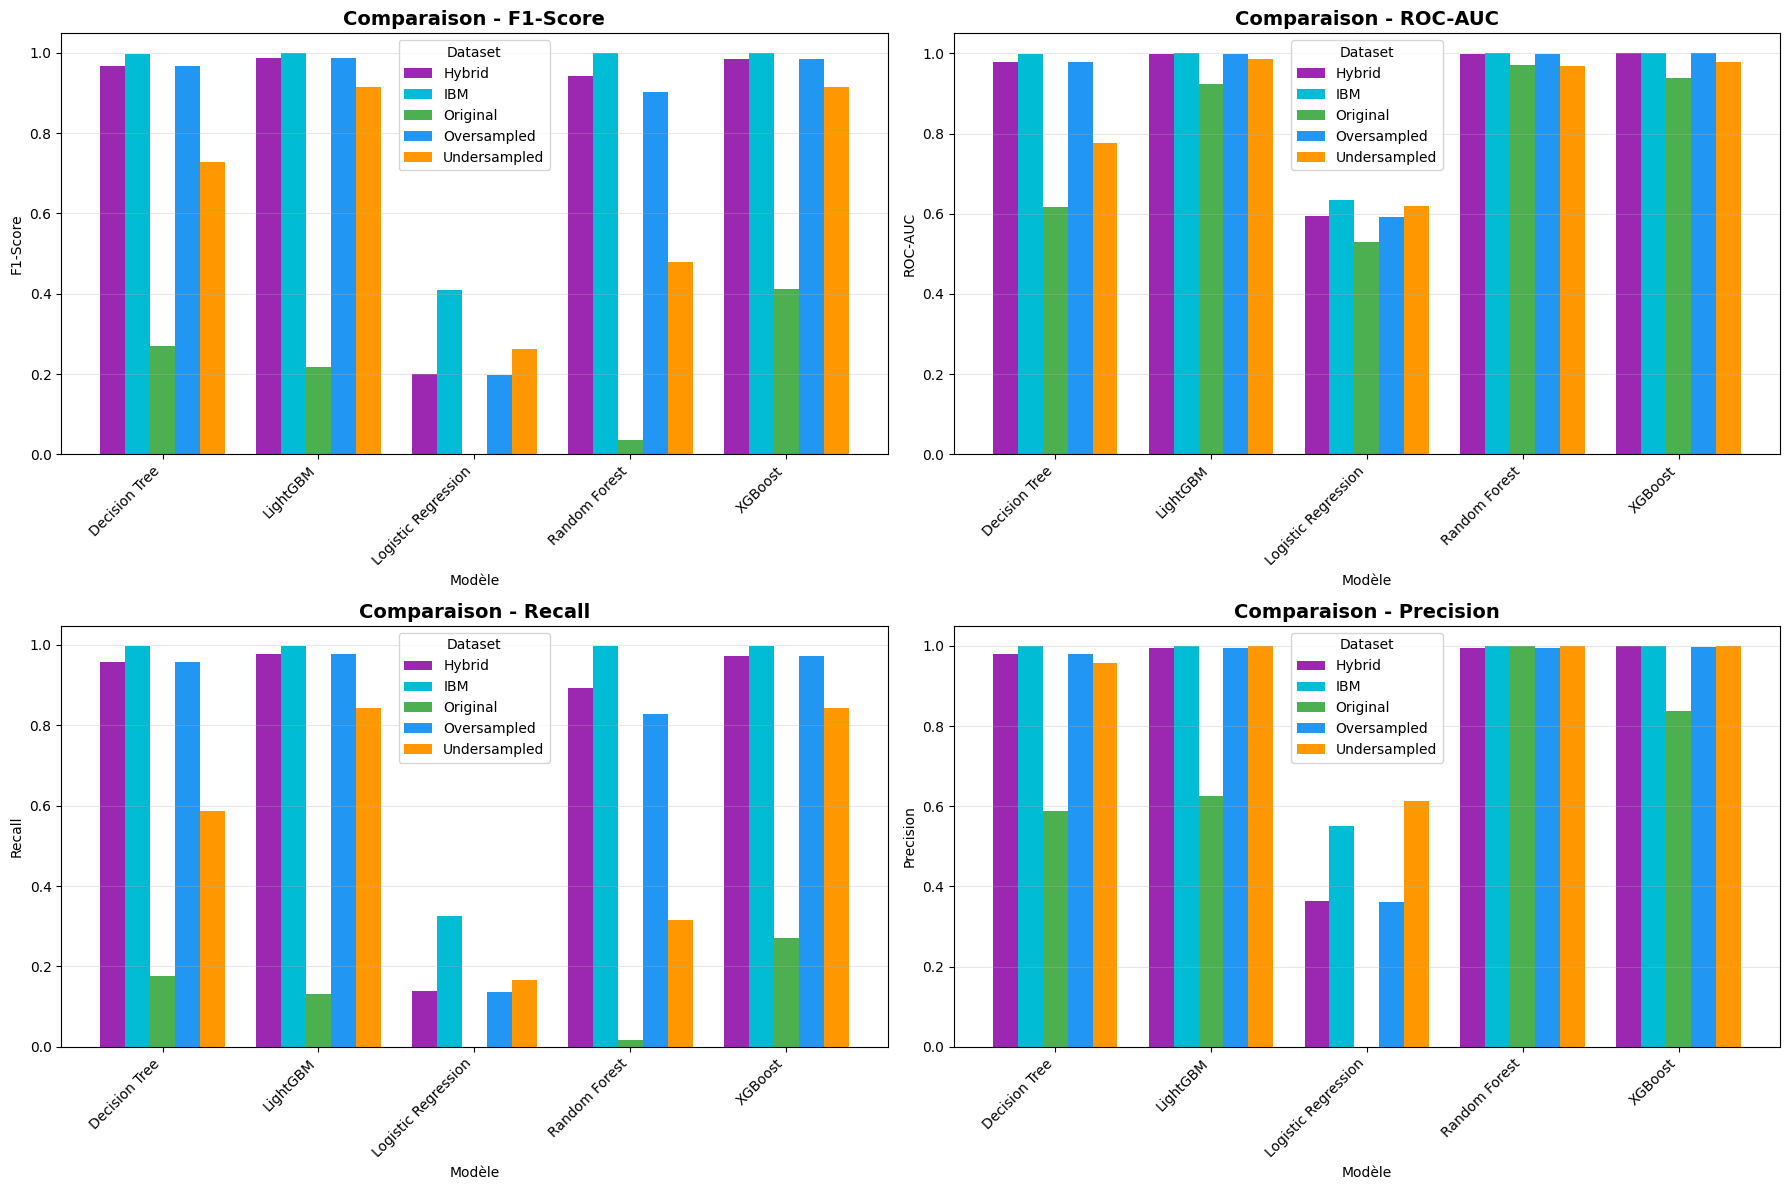

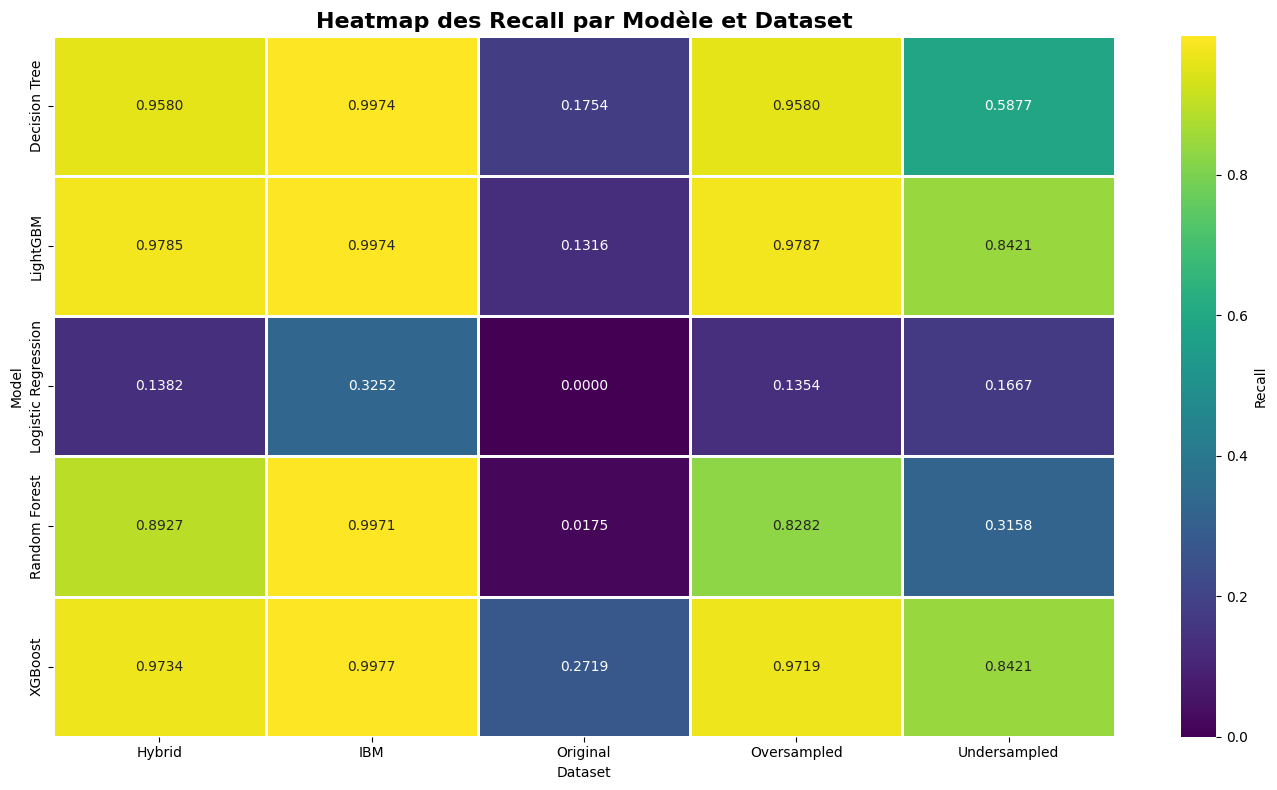

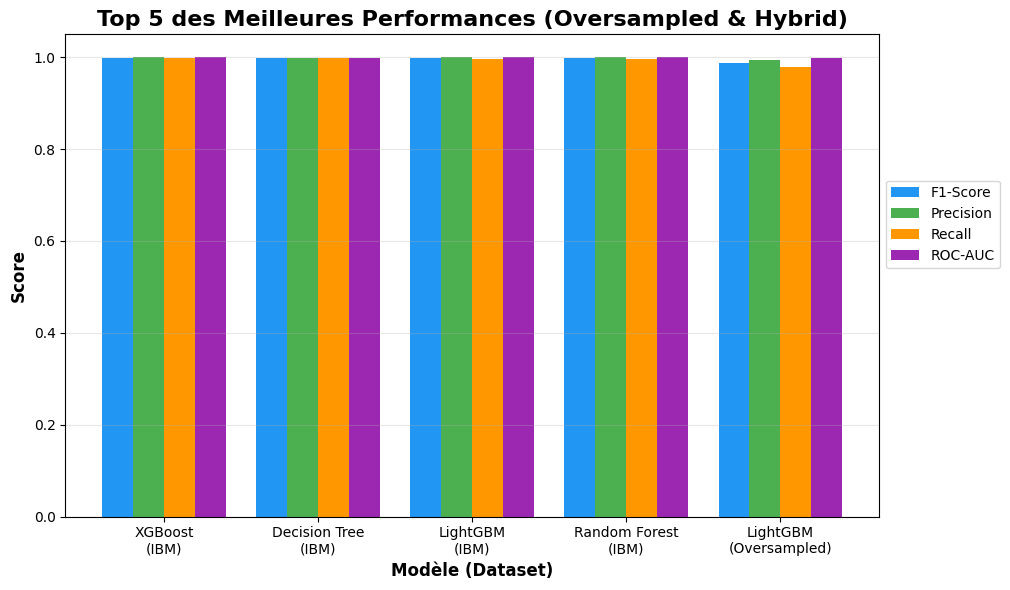


📊 Nombre de modèles affichés: 5
Datasets inclus: Oversampled, Hybrid


🔬 ANALYSE DU MEILLEUR MODÈLE : XGBoost sur IBM


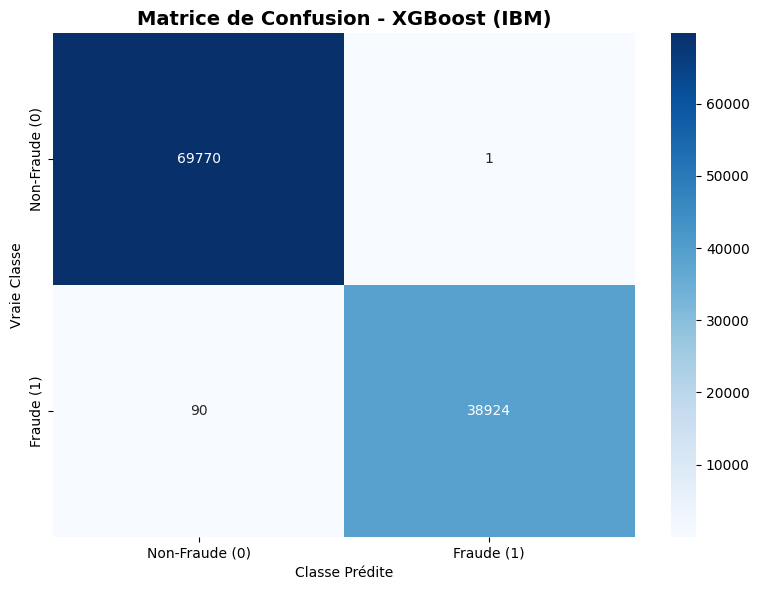


📊 Rapport de classification détaillé :
              precision    recall  f1-score   support

  Non-Fraude       1.00      1.00      1.00     69771
      Fraude       1.00      1.00      1.00     39014

    accuracy                           1.00    108785
   macro avg       1.00      1.00      1.00    108785
weighted avg       1.00      1.00      1.00    108785



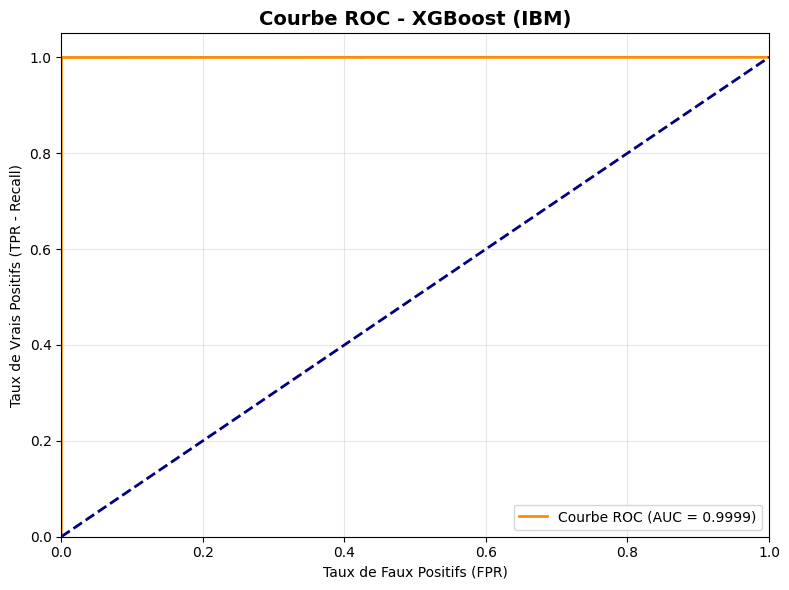

In [241]:
df_results = pd.DataFrame(results)
data_visualisation_pipeline(df_results, trained_models, y_val_splited)

# Data Evaluation Cleaning

In [242]:
import pandas as pd

def align_dataframes(df_train: pd.DataFrame, df_eval: pd.DataFrame) -> pd.DataFrame:
    train_cols = set(df_train.columns)
    eval_cols = set(df_eval.columns)
    
    print("="*60)
    print(f"📊 ALIGNEMENT DES COLONNES (Train vs Eval)")
    print("="*60)
    
    # 2. Identifier les colonnes dans eval qui ne sont PAS dans train (À SUPPRIMER)
    extra_cols_in_eval = [col for col in eval_cols if col not in train_cols]
    
    # 3. Identifier les colonnes dans train qui ne sont PAS dans eval (MANQUANTES)
    missing_cols_in_eval = [col for col in train_cols if col not in eval_cols]

    # --- Gestion des colonnes supplémentaires dans df_eval ---
    df_eval_aligned = df_eval.copy() # Travailler sur une copie

    if extra_cols_in_eval:
        df_eval_aligned = df_eval_aligned.drop(columns=extra_cols_in_eval, errors='ignore')
        print(f"⚠️ {len(extra_cols_in_eval)} colonnes SUPPRIMÉES de df_eval (non présentes dans df_train):")
        for col in extra_cols_in_eval:
            print(f"  - {col}")
    else:
        print("🎉 Aucune colonne supplémentaire trouvée dans df_eval.")

    # --- Gestion des colonnes manquantes dans df_eval ---
    print("\n--- Vérification des colonnes manquantes ---")
    if missing_cols_in_eval:
        # Avertissement : on ne peut pas les ajouter, mais on informe
        print(f"🚨 {len(missing_cols_in_eval)} colonnes MANQUANTES dans df_eval (présentes dans df_train):")
        for col in missing_cols_in_eval:
            print(f"  - {col}")
        print("🚨 ATTENTION: Les features manquantes ne peuvent pas être utilisées par le modèle entraîné!")
    else:
        print("✅ Aucune colonne manquante trouvée dans df_eval par rapport à df_train.")

    # --- Résumé ---
    print(f"\n✅ Alignement terminé.")
    print(f"  Shape de df_train : {df_train.shape}")
    print(f"  Shape de df_eval final : {df_eval_aligned.shape}")
        
    return df_eval_aligned

In [243]:
def get_best_model_for_prediction(df_results, trained_models):
    target_datasets = ['Oversampled', 'Hybrid', 'IBM']
    df_filtered_for_best = df_results[df_results['Dataset'].isin(target_datasets)].copy()
    df_filtered_for_best = df_filtered_for_best.sort_values('Recall', ascending=False)

    if df_filtered_for_best.empty:
        print(f"\n⚠️ Aucun modèle trouvé dans les datasets cibles ({', '.join(target_datasets)}).")
        # Retourne le meilleur modèle global si les cibles sont vides
        if not df_results.empty:
            best_model_row = df_results.sort_values('Recall', ascending=False).iloc[0]
            print(f"  -> Sélection du meilleur modèle global: {best_model_row['Model']} sur {best_model_row['Dataset']}.")
        else:
            print("  -> Aucun résultat de modèle disponible.")
            return None, None, None
    else:
        best_model_row = df_filtered_for_best.iloc[0]
        
    
    model_name = best_model_row['Model']
    dataset_name = best_model_row['Dataset']
    best_model_key = f"{model_name}_{dataset_name}"
    
    # 2. Récupération de l'objet modèle
    try:
        best_model_object = trained_models[best_model_key]['model']
        
        print(f"\n{'='*80}")
        print(f"🏆 MEILLEUR MODÈLE SÉLECTIONNÉ : {model_name} sur {dataset_name}")
        print(f"  - Recall: {best_model_row['Recall']:.4f}, ROC-AUC: {best_model_row['ROC-AUC']:.4f}")
        print(f"{'='*80}")
        
        return best_model_object, model_name, dataset_name
    
    except KeyError:
        print(f"❌ ERREUR: L'objet modèle '{best_model_key}' est introuvable dans 'trained_models'.")
        return None, None, None

In [253]:
def predict_real_data(model, X_test, model_name="ModelTest"):

    print("\n" + "="*80)
    print(f"🔮 Prédictions avec le modèle : {model_name}")
    print("="*80)
    
    start_time = time.time()
    
    try:
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = (y_pred_proba >= 0.3).astype(int)
        else:
            y_pred = model.predict(X_test)
            y_pred_proba = np.zeros_like(y_pred, dtype=float)
        
        predictions_df = pd.DataFrame({
            f"{model_name}_pred": y_pred,
            f"{model_name}_proba": y_pred_proba
        })
        
        print(f"✅ Prédiction terminée en {time.time() - start_time:.2f}s ({len(X_test)} échantillons)")
        return predictions_df

    except Exception as e:
        print(f"❌ Erreur lors de la prédiction : {e}")
        return None

In [245]:
df_evaluation_features = data_cleaning_pipeline(df_evaluation_features)
df_evaluation_features = data_preprocessing_pipeline(df_evaluation_features)
df_evaluation_features = align_dataframes(merged_df, df_evaluation_features)

  ✅ Colonne 'amount' nettoyée et convertie en float.
  ⚠️ Colonne 'credit_limit' non trouvée dans le DataFrame, ignorée.
  ⚠️ Colonne 'yearly_income' non trouvée dans le DataFrame, ignorée.
  ✅ Colonne 'date' convertie en datetime.
✅ Pipeline preprocessing terminé ✅
❌ ERREUR: La colonne 'target' est absente. L'analyse de corrélation est ignorée.

🗑️ Suppression finale des colonnes : 2 features supprimées.

✅ Pipeline terminé. Shape final du DataFrame : (90000, 13)
📊 ALIGNEMENT DES COLONNES (Train vs Eval)
⚠️ 4 colonnes SUPPRIMÉES de df_eval (non présentes dans df_train):
  - jour_de_la_semaine_indice
  - est_weekend
  - mois
  - jour

--- Vérification des colonnes manquantes ---
🚨 1 colonnes MANQUANTES dans df_eval (présentes dans df_train):
  - target
🚨 ATTENTION: Les features manquantes ne peuvent pas être utilisées par le modèle entraîné!

✅ Alignement terminé.
  Shape de df_train : (210000, 10)
  Shape de df_eval final : (90000, 9)
✅ Pipeline preprocessing terminé ✅
❌ ERREUR: La co

In [254]:
best_model, model_name, dataset_name = get_best_model_for_prediction(df_results, trained_models)

if best_model is not None:
    # Construction du nom du modèle pour la fonction de prédiction
    full_model_name = f"{model_name}_{dataset_name}"

    # Appel de votre fonction de prédiction
    predictions = predict_real_data(best_model, df_evaluation_features, model_name=full_model_name)
    
    if predictions is not None:
        print(f"✅ Prédictions pour {full_model_name} générées.")
else:
    print("Impossible de procéder à la prédiction car aucun modèle valide n'a été trouvé.")


🏆 MEILLEUR MODÈLE SÉLECTIONNÉ : XGBoost sur IBM
  - Recall: 0.9977, ROC-AUC: 0.9999

🔮 Prédictions avec le modèle : XGBoost_IBM
✅ Prédiction terminée en 0.03s (90000 échantillons)
✅ Prédictions pour XGBoost_IBM générées.


📊 RÉSUMÉ DES PRÉDICTIONS SUR LES DONNÉES D'ÉVALUATION

🤖 Modèle utilisé: XGBoost_IBM
📈 Nombre total de transactions: 90,000
🚨 Fraudes détectées: 44 (0.05%)
✅ Non-fraudes: 89,956 (99.95%)

📊 STATISTIQUES DES PROBABILITÉS DE FRAUDE:
  • Probabilité moyenne: 0.0011
  • Probabilité médiane: 0.0000
  • Probabilité min: 0.0000
  • Probabilité max: 0.9360
  • Écart-type: 0.0153

📈 DISTRIBUTION PAR TRANCHE DE PROBABILITÉ:
       0-25%:   89,947 (99.94%) █████████████████████████████████████████████████
      25-50%:       29 ( 0.03%) 
      50-75%:       10 ( 0.01%) 
     75-100%:       14 ( 0.02%) 

🔍 TOP 10 TRANSACTIONS LES PLUS SUSPECTES:
   1. Index  54709 | Proba: 0.9360 | Prédiction: 🚨 FRAUDE
   2. Index  64190 | Proba: 0.8997 | Prédiction: 🚨 FRAUDE
   3. Index   8325 | Proba: 0.8898 | Prédiction: 🚨 FRAUDE
   4. Index  55246 | Proba: 0.8824 | Prédiction: 🚨 FRAUDE
   5. Index  41940 | Proba: 0.8719 | Prédiction: 🚨 FRAUDE
   6. Index  48967 | Proba: 0.8381 | Prédiction: 🚨 FRAUDE
   7. Inde

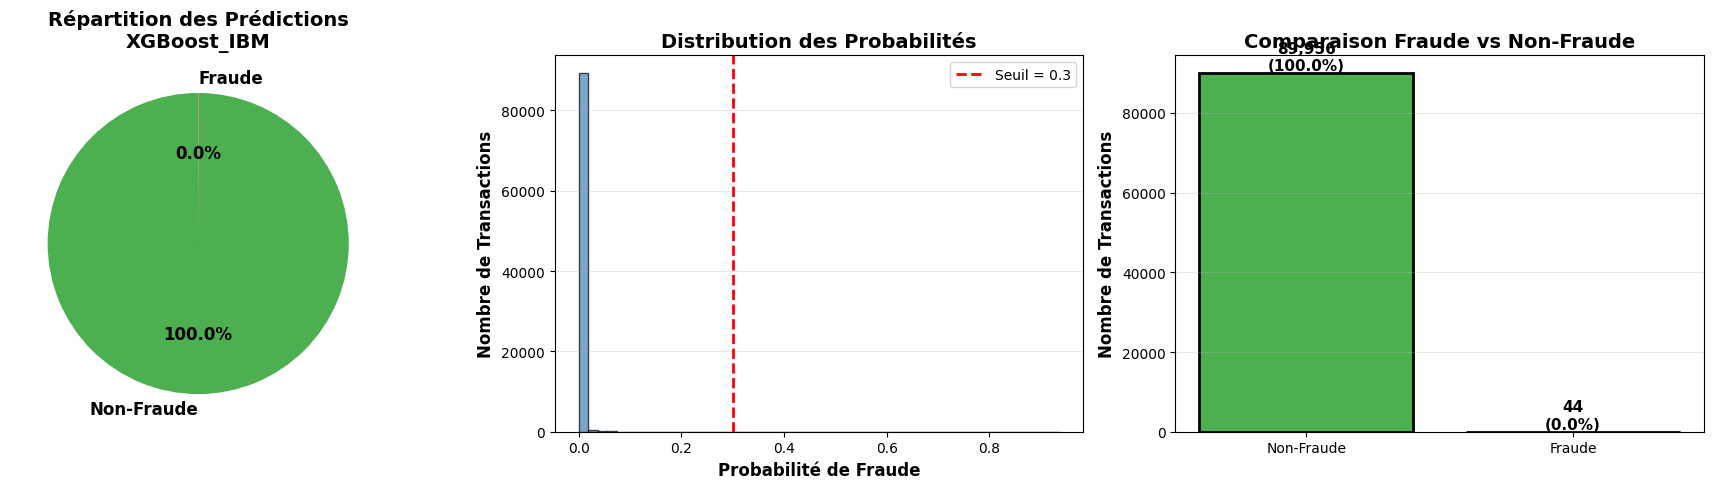


✅ Visualisations générées avec succès!



In [255]:
# ==================================================================================
# 📊 AFFICHAGE DÉTAILLÉ DES PRÉDICTIONS
# ==================================================================================

print("="*80)
print("📊 RÉSUMÉ DES PRÉDICTIONS SUR LES DONNÉES D'ÉVALUATION")
print("="*80 + "\n")

# Obtenir les colonnes de prédiction et de probabilité
pred_cols = [col for col in predictions.columns if col.endswith('_pred')]
proba_cols = [col for col in predictions.columns if col.endswith('_proba')]

if pred_cols:
    pred_col = pred_cols[0]  # Première colonne de prédiction
    proba_col = proba_cols[0] if proba_cols else None
    
    # Extraire le nom du modèle de la colonne
    model_display_name = pred_col.replace('_pred', '')
    
    # 1. Statistiques générales
    total_samples = len(predictions)
    fraud_detected = predictions[pred_col].sum()
    fraud_percentage = (fraud_detected / total_samples) * 100
    non_fraud = total_samples - fraud_detected
    
    print(f"🤖 Modèle utilisé: {model_display_name}")
    print(f"📈 Nombre total de transactions: {total_samples:,}")
    print(f"🚨 Fraudes détectées: {fraud_detected:,} ({fraud_percentage:.2f}%)")
    print(f"✅ Non-fraudes: {non_fraud:,} ({100-fraud_percentage:.2f}%)")
    
    # 2. Statistiques sur les probabilités (si disponibles)
    if proba_col:
        print(f"\n📊 STATISTIQUES DES PROBABILITÉS DE FRAUDE:")
        print(f"  • Probabilité moyenne: {predictions[proba_col].mean():.4f}")
        print(f"  • Probabilité médiane: {predictions[proba_col].median():.4f}")
        print(f"  • Probabilité min: {predictions[proba_col].min():.4f}")
        print(f"  • Probabilité max: {predictions[proba_col].max():.4f}")
        print(f"  • Écart-type: {predictions[proba_col].std():.4f}")
        
        # Distribution par tranches de probabilité
        print(f"\n📈 DISTRIBUTION PAR TRANCHE DE PROBABILITÉ:")
        bins = [0, 0.25, 0.5, 0.75, 1.0]
        labels = ['0-25%', '25-50%', '50-75%', '75-100%']
        prob_distribution = pd.cut(predictions[proba_col], bins=bins, labels=labels).value_counts().sort_index()
        
        for label, count in prob_distribution.items():
            pct = (count / total_samples) * 100
            bar = '█' * int(pct / 2)
            print(f"  {label:>10}: {count:>8,} ({pct:>5.2f}%) {bar}")
        
        # Top 10 transactions les plus suspectes
        print(f"\n🔍 TOP 10 TRANSACTIONS LES PLUS SUSPECTES:")
        top_suspicious = predictions.nlargest(10, proba_col)
        for idx, (i, row) in enumerate(top_suspicious.iterrows(), 1):
            pred_label = "🚨 FRAUDE" if row[pred_col] == 1 else "✅ NON-FRAUDE"
            print(f"  {idx:>2}. Index {i:>6} | Proba: {row[proba_col]:.4f} | Prédiction: {pred_label}")
    
    # 3. Visualisation
    print(f"\n" + "="*80)
    print("📊 VISUALISATION DES PRÉDICTIONS")
    print("="*80 + "\n")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Graphique 1: Pie chart des prédictions
    fraud_counts = predictions[pred_col].value_counts()
    colors_pie = ['#4CAF50', '#F44336']
    axes[0].pie(fraud_counts, labels=['Non-Fraude', 'Fraude'], autopct='%1.1f%%',
                colors=colors_pie, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    axes[0].set_title(f'Répartition des Prédictions\n{model_display_name}', 
                     fontsize=14, fontweight='bold')
    
    # Graphique 2: Histogramme des probabilités (si disponible)
    if proba_col:
        axes[1].hist(predictions[proba_col], bins=50, color='steelblue', 
                    edgecolor='black', alpha=0.7)
        axes[1].axvline(0.3, color='red', linestyle='--', linewidth=2, label='Seuil = 0.3')
        axes[1].set_xlabel('Probabilité de Fraude', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Nombre de Transactions', fontsize=12, fontweight='bold')
        axes[1].set_title('Distribution des Probabilités', fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].grid(axis='y', alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'Probabilités\nnon disponibles', 
                    ha='center', va='center', fontsize=14)
        axes[1].axis('off')
    
    # Graphique 3: Bar chart avec comparaison
    categories = ['Non-Fraude', 'Fraude']
    counts = [non_fraud, fraud_detected]
    colors_bar = ['#4CAF50', '#F44336']
    bars = axes[2].bar(categories, counts, color=colors_bar, edgecolor='black', linewidth=2)
    axes[2].set_ylabel('Nombre de Transactions', fontsize=12, fontweight='bold')
    axes[2].set_title('Comparaison Fraude vs Non-Fraude', fontsize=14, fontweight='bold')
    axes[2].grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{count:,}\n({count/total_samples*100:.1f}%)',
                    ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Visualisations générées avec succès!")

else:
    print("❌ Aucune colonne de prédiction trouvée dans le DataFrame 'predictions'.")

print("\n" + "="*80)

# Comparaison des Performances des Modèles Entraînés

📊 ANALYSE COMPARATIVE DES PERFORMANCES D'ENTRAÎNEMENT



/var/folders/87/44q727sx1wzdm8x65p5jb4z40000gn/T/ipykernel_41204/2338969025.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


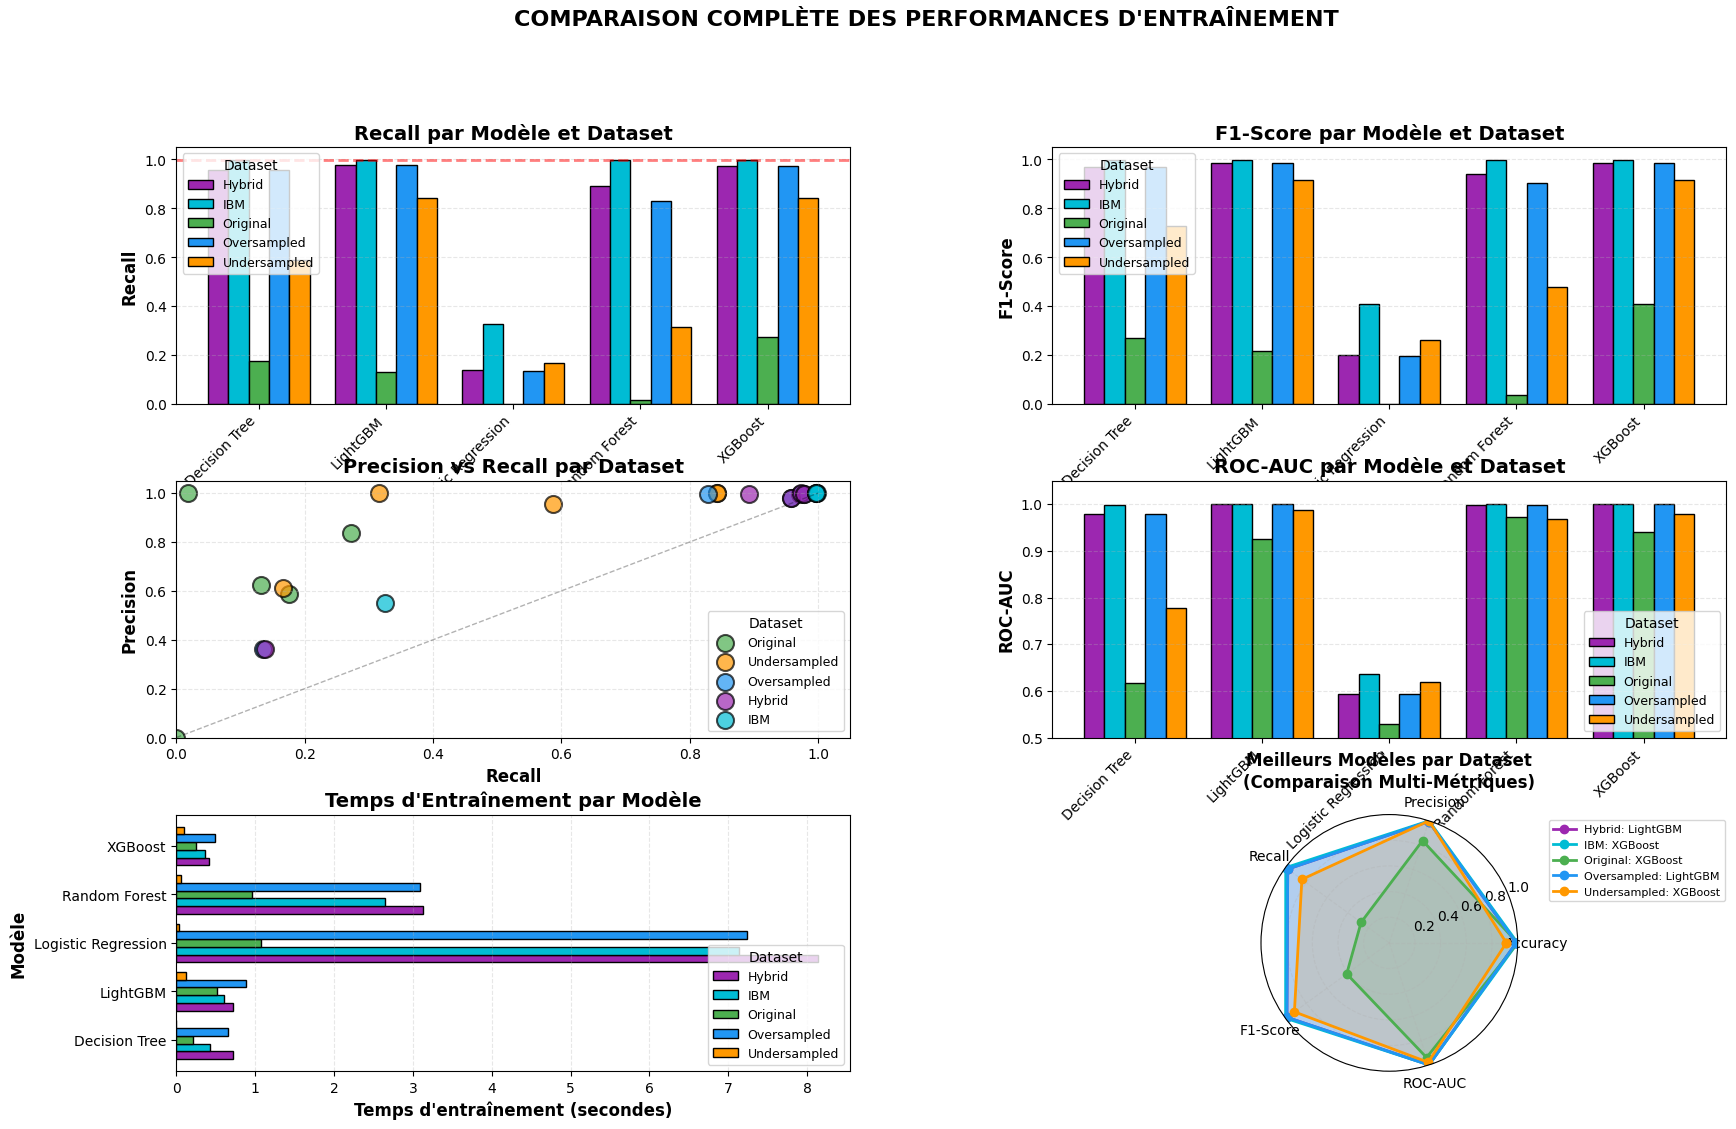


✅ Visualisations comparatives générées avec succès!


In [248]:
# ==================================================================================
# 📊 COMPARAISON COMPLÈTE DES MODÈLES ENTRAÎNÉS
# ==================================================================================

print("="*80)
print("📊 ANALYSE COMPARATIVE DES PERFORMANCES D'ENTRAÎNEMENT")
print("="*80 + "\n")

# 1. Créer une figure avec 6 sous-graphiques
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Palette de couleurs pour les datasets
dataset_colors = {
    'Original': '#4CAF50',
    'Undersampled': '#FF9800',
    'Oversampled': '#2196F3',
    'Hybrid': '#9C27B0',
    'IBM': '#00BCD4'
}

# ==================================================================================
# GRAPHIQUE 1: Comparaison Recall par Modèle et Dataset
# ==================================================================================
ax1 = fig.add_subplot(gs[0, 0])
pivot_recall = df_results.pivot(index='Model', columns='Dataset', values='Recall')
colors = [dataset_colors.get(col, 'gray') for col in pivot_recall.columns]

pivot_recall.plot(kind='bar', ax=ax1, color=colors, width=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Recall par Modèle et Dataset', fontsize=14, fontweight='bold')
ax1.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax1.set_xlabel('Modèle', fontsize=12, fontweight='bold')
ax1.legend(title='Dataset', loc='upper left', fontsize=9)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_ylim([0, 1.05])

# Ajouter une ligne horizontale pour le meilleur recall
best_recall = df_results['Recall'].max()
ax1.axhline(best_recall, color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'Meilleur: {best_recall:.4f}')

# ==================================================================================
# GRAPHIQUE 2: Comparaison F1-Score par Modèle et Dataset
# ==================================================================================
ax2 = fig.add_subplot(gs[0, 1])
pivot_f1 = df_results.pivot(index='Model', columns='Dataset', values='F1-Score')

pivot_f1.plot(kind='bar', ax=ax2, color=colors, width=0.8, edgecolor='black', linewidth=1)
ax2.set_title('F1-Score par Modèle et Dataset', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_xlabel('Modèle', fontsize=12, fontweight='bold')
ax2.legend(title='Dataset', loc='upper left', fontsize=9)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_ylim([0, 1.05])

# ==================================================================================
# GRAPHIQUE 3: Precision vs Recall (Scatter Plot)
# ==================================================================================
ax3 = fig.add_subplot(gs[1, 0])

for dataset in df_results['Dataset'].unique():
    data = df_results[df_results['Dataset'] == dataset]
    ax3.scatter(data['Recall'], data['Precision'], 
               label=dataset, s=150, alpha=0.7, 
               color=dataset_colors.get(dataset, 'gray'),
               edgecolors='black', linewidth=1.5)

ax3.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax3.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax3.set_title('Precision vs Recall par Dataset', fontsize=14, fontweight='bold')
ax3.legend(title='Dataset', loc='best', fontsize=9)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_xlim([0, 1.05])
ax3.set_ylim([0, 1.05])

# Ligne diagonale pour référence
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)

# ==================================================================================
# GRAPHIQUE 4: ROC-AUC par Modèle (Grouped Bar Chart)
# ==================================================================================
ax4 = fig.add_subplot(gs[1, 1])
pivot_auc = df_results.pivot(index='Model', columns='Dataset', values='ROC-AUC')

pivot_auc.plot(kind='bar', ax=ax4, color=colors, width=0.8, edgecolor='black', linewidth=1)
ax4.set_title('ROC-AUC par Modèle et Dataset', fontsize=14, fontweight='bold')
ax4.set_ylabel('ROC-AUC', fontsize=12, fontweight='bold')
ax4.set_xlabel('Modèle', fontsize=12, fontweight='bold')
ax4.legend(title='Dataset', loc='lower right', fontsize=9)
ax4.grid(axis='y', alpha=0.3, linestyle='--')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.set_ylim([0.5, 1.05])

# ==================================================================================
# GRAPHIQUE 5: Temps d'entraînement par Modèle
# ==================================================================================
ax5 = fig.add_subplot(gs[2, 0])
pivot_time = df_results.pivot(index='Model', columns='Dataset', values='Train Time (s)')

pivot_time.plot(kind='barh', ax=ax5, color=colors, width=0.8, edgecolor='black', linewidth=1)
ax5.set_xlabel('Temps d\'entraînement (secondes)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Modèle', fontsize=12, fontweight='bold')
ax5.set_title('Temps d\'Entraînement par Modèle', fontsize=14, fontweight='bold')
ax5.legend(title='Dataset', loc='lower right', fontsize=9)
ax5.grid(axis='x', alpha=0.3, linestyle='--')

# ==================================================================================
# GRAPHIQUE 6: Radar Chart - Comparaison Multi-Métriques du Meilleur Modèle par Dataset
# ==================================================================================
ax6 = fig.add_subplot(gs[2, 1], projection='polar')

# Sélectionner le meilleur modèle par dataset (basé sur Recall)
best_models_per_dataset = df_results.loc[df_results.groupby('Dataset')['Recall'].idxmax()]

metrics_radar = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
num_vars = len(metrics_radar)

# Calculer les angles pour chaque métrique
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Fermer le cercle

for idx, row in best_models_per_dataset.iterrows():
    values = [row[metric] for metric in metrics_radar]
    values += values[:1]  # Fermer le cercle
    
    color = dataset_colors.get(row['Dataset'], 'gray')
    ax6.plot(angles, values, 'o-', linewidth=2, label=f"{row['Dataset']}: {row['Model']}", color=color)
    ax6.fill(angles, values, alpha=0.15, color=color)

ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(metrics_radar, fontsize=10)
ax6.set_ylim(0, 1)
ax6.set_title('Meilleurs Modèles par Dataset\n(Comparaison Multi-Métriques)', 
             fontsize=12, fontweight='bold', pad=20)
ax6.legend(loc='upper left', bbox_to_anchor=(1.1, 1.0), fontsize=8)
ax6.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('COMPARAISON COMPLÈTE DES PERFORMANCES D\'ENTRAÎNEMENT', 
            fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("\n✅ Visualisations comparatives générées avec succès!")

In [249]:
# ==================================================================================
# 📊 TABLEAU RÉCAPITULATIF DES PERFORMANCES
# ==================================================================================

print("\n" + "="*80)
print("📋 TABLEAU RÉCAPITULATIF DES PERFORMANCES PAR DATASET")
print("="*80 + "\n")

# Calculer les statistiques moyennes par dataset
dataset_summary = df_results.groupby('Dataset').agg({
    'Accuracy': 'mean',
    'Precision': 'mean',
    'Recall': 'mean',
    'F1-Score': 'mean',
    'ROC-AUC': 'mean',
    'Train Time (s)': 'mean'
}).round(4)

dataset_summary = dataset_summary.sort_values('Recall', ascending=False)

print("Moyennes des métriques par Dataset:\n")
print(dataset_summary.to_string())

# Identifier le meilleur modèle pour chaque dataset
print("\n" + "="*80)
print("🏆 MEILLEUR MODÈLE PAR DATASET (basé sur Recall)")
print("="*80 + "\n")

best_per_dataset = df_results.loc[df_results.groupby('Dataset')['Recall'].idxmax()]
best_per_dataset_display = best_per_dataset[['Dataset', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Train Time (s)']]
best_per_dataset_display = best_per_dataset_display.sort_values('Recall', ascending=False)

print(best_per_dataset_display.to_string(index=False))

# Top 10 des combinaisons modèle-dataset
print("\n" + "="*80)
print("🥇 TOP 10 DES MEILLEURES COMBINAISONS (Modèle × Dataset)")
print("="*80 + "\n")

top_10 = df_results.nlargest(10, 'Recall')[['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Train Time (s)']]
print(top_10.to_string(index=False))

print("\n" + "="*80)


📋 TABLEAU RÉCAPITULATIF DES PERFORMANCES PAR DATASET

Moyennes des métriques par Dataset:

              Accuracy  Precision  Recall  F1-Score  ROC-AUC  Train Time (s)
Dataset                                                                     
IBM             0.9318     0.9101  0.8630    0.8807   0.9268           2.240
Hybrid          0.8918     0.8659  0.7882    0.8164   0.9141           2.626
Oversampled     0.8866     0.8656  0.7745    0.8081   0.9138           2.472
Undersampled    0.7356     0.9140  0.5509    0.6598   0.8660           0.064
Original        0.9985     0.6102  0.1193    0.1865   0.7967           0.604

🏆 MEILLEUR MODÈLE PAR DATASET (basé sur Recall)

     Dataset    Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Train Time (s)
         IBM  XGBoost  0.999163   0.999974 0.997693  0.998832 0.999930            0.37
 Oversampled LightGBM  0.989160   0.994489 0.978684  0.986523 0.999546            0.89
      Hybrid LightGBM  0.989049   0.994424 0.978474  0.986


🔥 HEATMAP COMPARATIVE DES PERFORMANCES



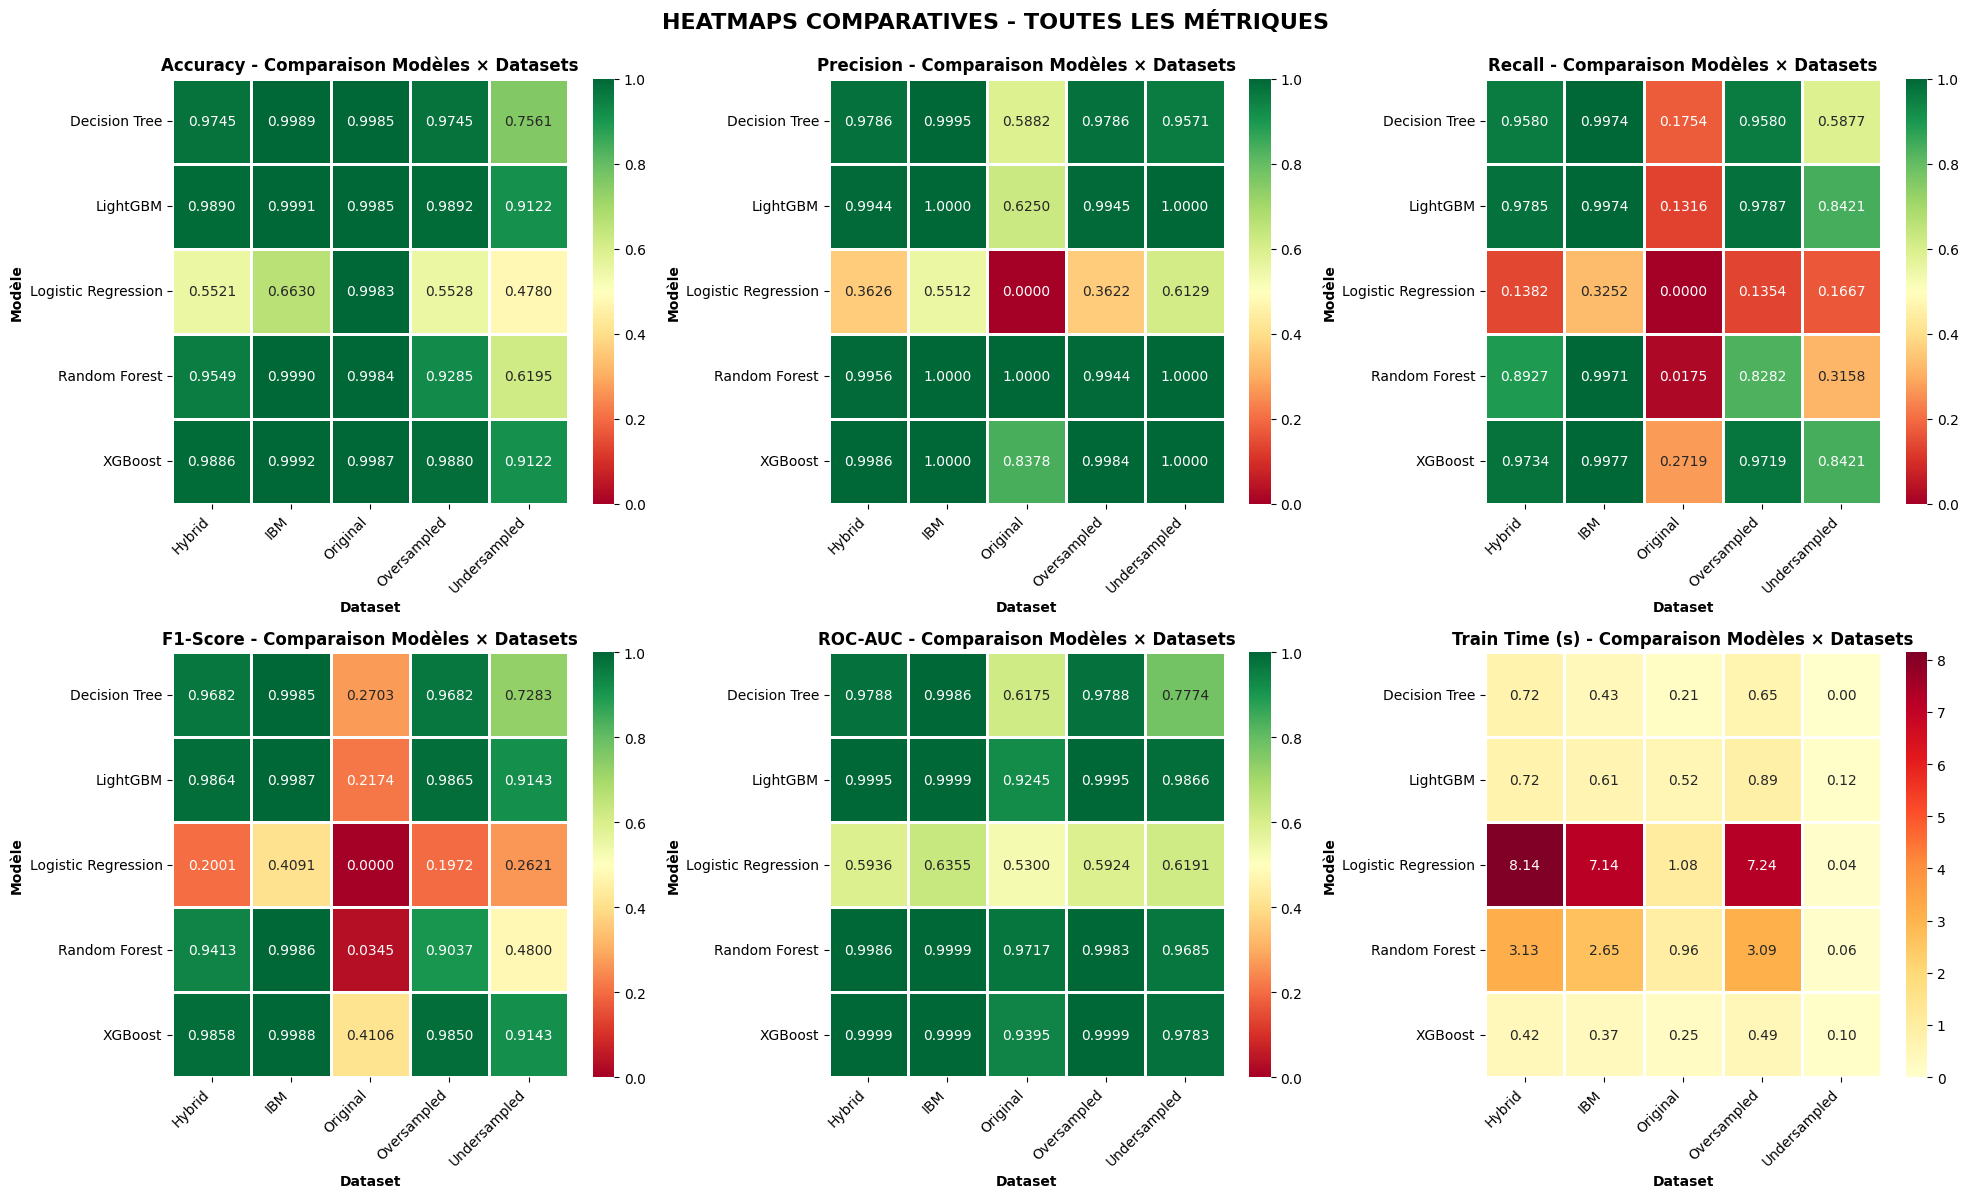

✅ Heatmaps comparatives générées avec succès!


In [250]:
# ==================================================================================
# 📊 HEATMAP COMPARATIVE AVANCÉE
# ==================================================================================

print("\n" + "="*80)
print("🔥 HEATMAP COMPARATIVE DES PERFORMANCES")
print("="*80 + "\n")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Train Time (s)']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Créer le pivot
    heatmap_data = df_results.pivot(index='Model', columns='Dataset', values=metric)
    
    # Choisir la palette de couleur
    if metric == 'Train Time (s)':
        cmap = 'YlOrRd'  # Plus c'est rouge, plus c'est lent
    else:
        cmap = 'RdYlGn'  # Plus c'est vert, mieux c'est
    
    # Créer la heatmap
    sns.heatmap(heatmap_data, annot=True, fmt='.4f' if metric != 'Train Time (s)' else '.2f',
                cmap=cmap, cbar=True, linewidths=1, linecolor='white', ax=ax,
                vmin=heatmap_data.min().min() if metric == 'Train Time (s)' else 0,
                vmax=heatmap_data.max().max() if metric == 'Train Time (s)' else 1)
    
    ax.set_title(f'{metric} - Comparaison Modèles × Datasets', fontsize=12, fontweight='bold')
    ax.set_xlabel('Dataset', fontsize=10, fontweight='bold')
    ax.set_ylabel('Modèle', fontsize=10, fontweight='bold')
    
    # Rotation des labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.suptitle('HEATMAPS COMPARATIVES - TOUTES LES MÉTRIQUES', 
            fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("✅ Heatmaps comparatives générées avec succès!")


🔬 ANALYSE DÉTAILLÉE PAR MODÈLE



/var/folders/87/44q727sx1wzdm8x65p5jb4z40000gn/T/ipykernel_41204/805492331.py:55: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


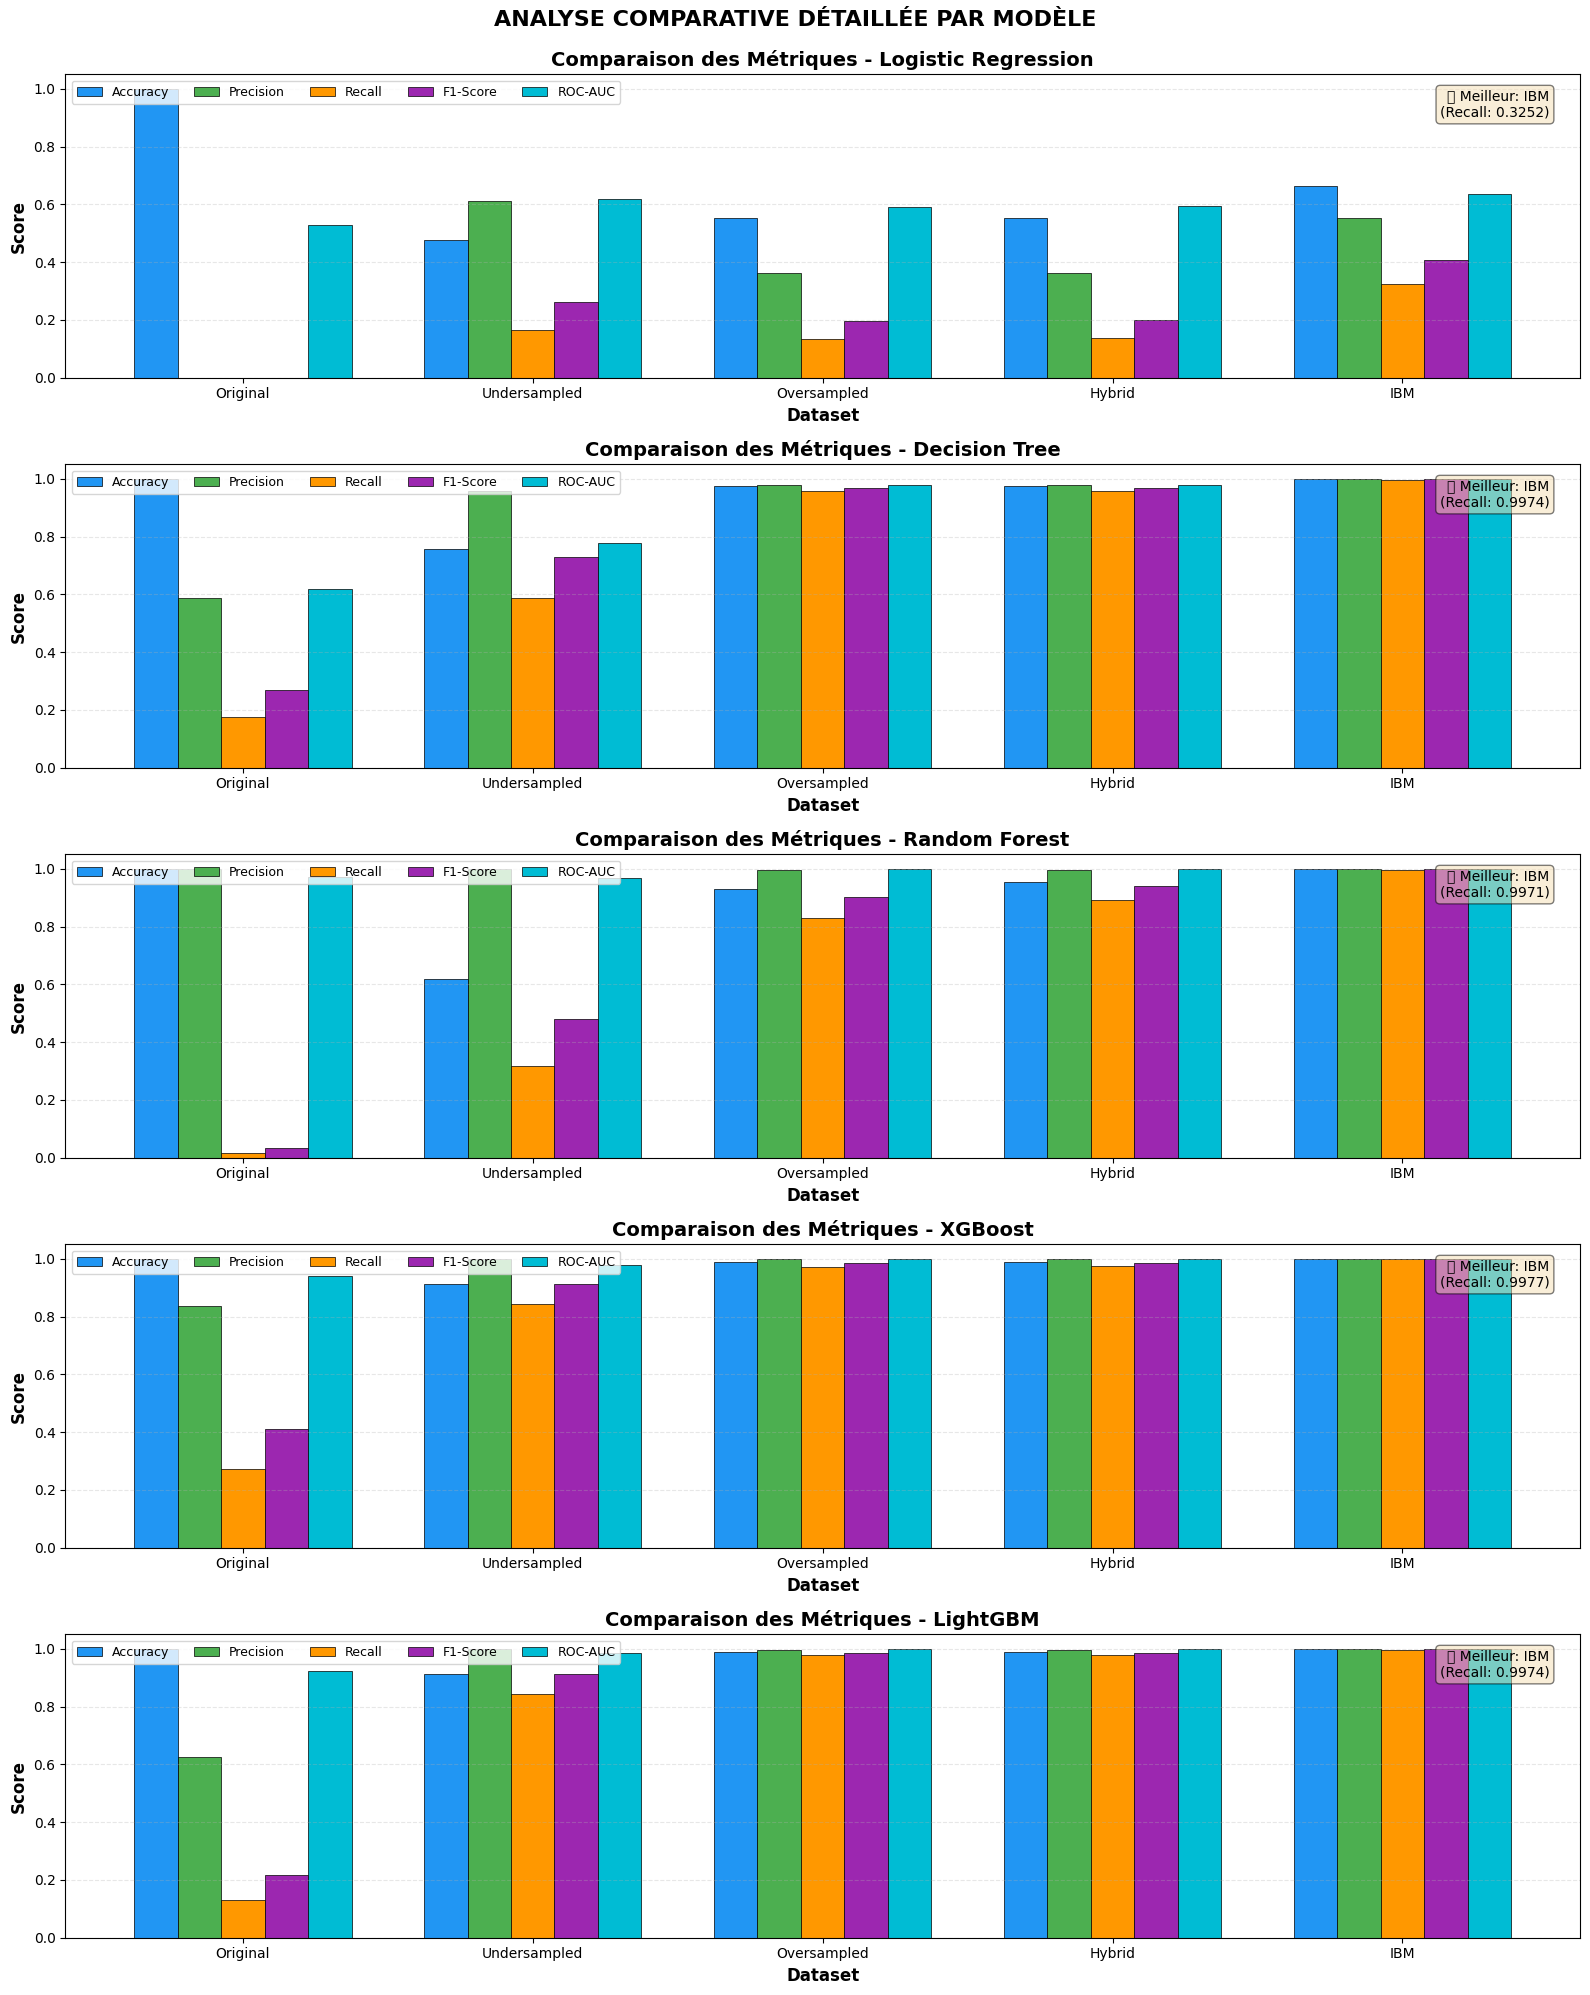

✅ Analyse par modèle terminée!


In [251]:
# ==================================================================================
# 📊 ANALYSE COMPARATIVE PAR MODÈLE
# ==================================================================================

print("\n" + "="*80)
print("🔬 ANALYSE DÉTAILLÉE PAR MODÈLE")
print("="*80 + "\n")

fig, axes = plt.subplots(len(models), 1, figsize=(16, 4 * len(models)))

if len(models) == 1:
    axes = [axes]  # Pour gérer le cas d'un seul modèle

for idx, model_name in enumerate(df_results['Model'].unique()):
    ax = axes[idx]
    
    # Filtrer les données pour ce modèle
    model_data = df_results[df_results['Model'] == model_name]
    
    # Préparer les données
    datasets_list = model_data['Dataset'].tolist()
    x = np.arange(len(datasets_list))
    width = 0.15
    
    # Tracer les barres pour chaque métrique
    metrics_to_compare = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    colors_metrics = ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0', '#00BCD4']
    
    for i, metric in enumerate(metrics_to_compare):
        values = model_data[metric].tolist()
        ax.bar(x + i * width - 2*width, values, width, 
              label=metric, color=colors_metrics[i], edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Comparaison des Métriques - {model_name}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets_list, rotation=0, fontsize=10)
    ax.legend(loc='upper left', ncol=5, fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])
    
    # Ajouter une annotation pour le meilleur dataset
    best_idx = model_data['Recall'].idxmax()
    best_dataset = model_data.loc[best_idx, 'Dataset']
    best_recall = model_data.loc[best_idx, 'Recall']
    
    ax.text(0.98, 0.95, f'🏆 Meilleur: {best_dataset}\n(Recall: {best_recall:.4f})',
           transform=ax.transAxes, fontsize=10, verticalalignment='top',
           horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('ANALYSE COMPARATIVE DÉTAILLÉE PAR MODÈLE', 
            fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("✅ Analyse par modèle terminée!")

In [ ]:
# ==================================================================================
# 🔍 ANALYSE APPROFONDIE: XGBoost
# ==================================================================================

print("="*80)
print("🚀 ANALYSE DÉTAILLÉE DU MODÈLE XGBoost SUR TOUS LES DATASETS")
print("="*80 + "\n")

# Filtrer les données pour XGBoost uniquement
xgboost_data = df_results[df_results['Model'] == 'XGBoost'].copy()

if xgboost_data.empty:
    print("❌ Aucune donnée trouvée pour XGBoost.")
else:
    # Trier par Recall décroissant
    xgboost_data = xgboost_data.sort_values('Recall', ascending=False)
    
    # ==================================================================================
    # 1. TABLEAU RÉCAPITULATIF XGBoost
    # ==================================================================================
    print("📋 PERFORMANCES DE XGBoost PAR DATASET:\n")
    display_cols = ['Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Train Time (s)']
    print(xgboost_data[display_cols].to_string(index=False))
    
    # Meilleur et pire dataset
    best_dataset = xgboost_data.iloc[0]
    worst_dataset = xgboost_data.iloc[-1]
    
    print("\n" + "="*80)
    print(f"🏆 MEILLEUR DATASET: {best_dataset['Dataset']}")
    print("="*80)
    print(f"  • Recall: {best_dataset['Recall']:.4f}")
    print(f"  • F1-Score: {best_dataset['F1-Score']:.4f}")
    print(f"  • ROC-AUC: {best_dataset['ROC-AUC']:.4f}")
    print(f"  • Precision: {best_dataset['Precision']:.4f}")
    print(f"  • Temps d'entraînement: {best_dataset['Train Time (s)']:.2f}s")
    
    print("\n" + "="*80)
    print(f"📉 DATASET LE MOINS PERFORMANT: {worst_dataset['Dataset']}")
    print("="*80)
    print(f"  • Recall: {worst_dataset['Recall']:.4f}")
    print(f"  • F1-Score: {worst_dataset['F1-Score']:.4f}")
    print(f"  • ROC-AUC: {worst_dataset['ROC-AUC']:.4f}")
    print(f"  • Precision: {worst_dataset['Precision']:.4f}")
    print(f"  • Temps d'entraînement: {worst_dataset['Train Time (s)']:.2f}s")
    
    # ==================================================================================
    # 2. VISUALISATIONS DÉTAILLÉES
    # ==================================================================================
    print("\n" + "="*80)
    print("📊 GÉNÉRATION DES VISUALISATIONS DÉTAILLÉES POUR XGBoost")
    print("="*80 + "\n")
    
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    
    # Couleurs pour les datasets
    dataset_colors_xgb = {
        'Original': '#4CAF50',
        'Undersampled': '#FF9800',
        'Oversampled': '#2196F3',
        'Hybrid': '#9C27B0',
        'IBM': '#00BCD4'
    }
    
    colors_bars = [dataset_colors_xgb.get(ds, 'gray') for ds in xgboost_data['Dataset']]
    
    # ==================================================================================
    # GRAPHIQUE 1: Comparaison de toutes les métriques (Bar Chart)
    # ==================================================================================
    ax1 = fig.add_subplot(gs[0, :])
    
    datasets_list = xgboost_data['Dataset'].tolist()
    x = np.arange(len(datasets_list))
    width = 0.15
    
    metrics_to_compare = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    colors_metrics = ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0', '#00BCD4']
    
    for i, metric in enumerate(metrics_to_compare):
        values = xgboost_data[metric].tolist()
        bars = ax1.bar(x + i * width - 2*width, values, width, 
                      label=metric, color=colors_metrics[i], 
                      edgecolor='black', linewidth=1)
        
        # Ajouter les valeurs sur les barres
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=8)
    
    ax1.set_xlabel('Dataset', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=13, fontweight='bold')
    ax1.set_title('XGBoost - Comparaison de Toutes les Métriques par Dataset', 
                 fontsize=15, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets_list, rotation=0, fontsize=11)
    ax1.legend(loc='upper left', ncol=5, fontsize=10)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_ylim([0, 1.1])
    
    # ==================================================================================
    # GRAPHIQUE 2: Recall par Dataset (Bar Chart avec gradient)
    # ==================================================================================
    ax2 = fig.add_subplot(gs[1, 0])
    
    bars = ax2.barh(xgboost_data['Dataset'], xgboost_data['Recall'], 
                    color=colors_bars, edgecolor='black', linewidth=1.5)
    
    # Ajouter les valeurs
    for i, (bar, val) in enumerate(zip(bars, xgboost_data['Recall'])):
        ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.4f}', va='center', fontweight='bold', fontsize=10)
    
    ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax2.set_title('XGBoost - Recall par Dataset', fontsize=13, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.set_xlim([0, 1.05])
    
    # Ligne de référence pour le meilleur
    ax2.axvline(xgboost_data['Recall'].max(), color='red', 
               linestyle='--', linewidth=2, alpha=0.5)
    
    # ==================================================================================
    # GRAPHIQUE 3: F1-Score par Dataset
    # ==================================================================================
    ax3 = fig.add_subplot(gs[1, 1])
    
    bars = ax3.barh(xgboost_data['Dataset'], xgboost_data['F1-Score'], 
                    color=colors_bars, edgecolor='black', linewidth=1.5)
    
    for i, (bar, val) in enumerate(zip(bars, xgboost_data['F1-Score'])):
        ax3.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.4f}', va='center', fontweight='bold', fontsize=10)
    
    ax3.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
    ax3.set_title('XGBoost - F1-Score par Dataset', fontsize=13, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3, linestyle='--')
    ax3.set_xlim([0, 1.05])
    
    # ==================================================================================
    # GRAPHIQUE 4: ROC-AUC par Dataset
    # ==================================================================================
    ax4 = fig.add_subplot(gs[1, 2])
    
    bars = ax4.barh(xgboost_data['Dataset'], xgboost_data['ROC-AUC'], 
                    color=colors_bars, edgecolor='black', linewidth=1.5)
    
    for i, (bar, val) in enumerate(zip(bars, xgboost_data['ROC-AUC'])):
        ax4.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.4f}', va='center', fontweight='bold', fontsize=10)
    
    ax4.set_xlabel('ROC-AUC', fontsize=12, fontweight='bold')
    ax4.set_title('XGBoost - ROC-AUC par Dataset', fontsize=13, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3, linestyle='--')
    ax4.set_xlim([0.5, 1.05])
    
    # ==================================================================================
    # GRAPHIQUE 5: Radar Chart - Vue d'ensemble des métriques
    # ==================================================================================
    ax5 = fig.add_subplot(gs[2, 0], projection='polar')
    
    metrics_radar = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    num_vars = len(metrics_radar)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    for idx, row in xgboost_data.iterrows():
        values = [row[metric] for metric in metrics_radar]
        values += values[:1]
        
        color = dataset_colors_xgb.get(row['Dataset'], 'gray')
        ax5.plot(angles, values, 'o-', linewidth=2, label=row['Dataset'], color=color)
        ax5.fill(angles, values, alpha=0.15, color=color)
    
    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(metrics_radar, fontsize=10)
    ax5.set_ylim(0, 1)
    ax5.set_title('XGBoost - Radar Chart\n(Toutes Métriques)', 
                 fontsize=12, fontweight='bold', pad=20)
    ax5.legend(loc='upper left', bbox_to_anchor=(1.15, 1.0), fontsize=9)
    ax5.grid(True, linestyle='--', alpha=0.3)
    
    # ==================================================================================
    # GRAPHIQUE 6: Precision vs Recall (Scatter Plot)
    # ==================================================================================
    ax6 = fig.add_subplot(gs[2, 1])
    
    for idx, row in xgboost_data.iterrows():
        color = dataset_colors_xgb.get(row['Dataset'], 'gray')
        ax6.scatter(row['Recall'], row['Precision'], 
                   s=300, alpha=0.7, color=color,
                   edgecolors='black', linewidth=2)
        ax6.annotate(row['Dataset'], 
                    (row['Recall'], row['Precision']),
                    textcoords="offset points", xytext=(0,10),
                    ha='center', fontsize=9, fontweight='bold')
    
    ax6.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax6.set_title('XGBoost - Precision vs Recall', fontsize=13, fontweight='bold')
    ax6.grid(True, alpha=0.3, linestyle='--')
    ax6.set_xlim([0, 1.05])
    ax6.set_ylim([0, 1.05])
    ax6.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
    
    # ==================================================================================
    # GRAPHIQUE 7: Temps d'entraînement par Dataset
    # ==================================================================================
    ax7 = fig.add_subplot(gs[2, 2])
    
    bars = ax7.bar(xgboost_data['Dataset'], xgboost_data['Train Time (s)'], 
                   color=colors_bars, edgecolor='black', linewidth=1.5)
    
    for bar, val in zip(bars, xgboost_data['Train Time (s)']):
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{val:.2f}s', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)
    
    ax7.set_ylabel('Temps (secondes)', fontsize=12, fontweight='bold')
    ax7.set_xlabel('Dataset', fontsize=12, fontweight='bold')
    ax7.set_title('XGBoost - Temps d\'Entraînement', fontsize=13, fontweight='bold')
    ax7.grid(axis='y', alpha=0.3, linestyle='--')
    ax7.set_xticklabels(ax7.get_xticklabels(), rotation=45, ha='right')
    
    plt.suptitle('🚀 ANALYSE COMPLÈTE: XGBoost SUR TOUS LES DATASETS', 
                fontsize=17, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()
    
    # ==================================================================================
    # 3. ANALYSE COMPARATIVE AVEC AUTRES MODÈLES
    # ==================================================================================
    print("\n" + "="*80)
    print("📊 COMPARAISON: XGBoost vs Autres Modèles (sur meilleur dataset)")
    print("="*80 + "\n")
    
    best_xgb_dataset = best_dataset['Dataset']
    all_models_on_best = df_results[df_results['Dataset'] == best_xgb_dataset].copy()
    all_models_on_best = all_models_on_best.sort_values('Recall', ascending=False)
    
    print(f"Dataset sélectionné: {best_xgb_dataset}\n")
    print(all_models_on_best[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Train Time (s)']].to_string(index=False))
    
    # Position de XGBoost dans le classement
    xgb_position = all_models_on_best[all_models_on_best['Model'] == 'XGBoost'].index[0]
    xgb_rank = all_models_on_best.index.get_loc(xgb_position) + 1
    
    print(f"\n🏆 XGBoost se classe #{xgb_rank} sur {len(all_models_on_best)} modèles pour le dataset '{best_xgb_dataset}'")
    
    print("\n✅ Analyse approfondie de XGBoost terminée!")
    print("="*80)

# Analyse Approfondie: XGBoost

🚀 ANALYSE DÉTAILLÉE DU MODÈLE XGBoost SUR TOUS LES DATASETS

📋 PERFORMANCES DE XGBoost PAR DATASET:

     Dataset  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Train Time (s)
         IBM  0.999163   0.999974 0.997693  0.998832 0.999930            0.37
      Hybrid  0.988640   0.998555 0.973387  0.985811 0.999888            0.42
 Oversampled  0.987967   0.998402 0.971874  0.984959 0.999893            0.49
Undersampled  0.912195   1.000000 0.842105  0.914286 0.978311            0.10
    Original  0.998726   0.837838 0.271930  0.410596 0.939489            0.25

🏆 MEILLEUR DATASET: IBM
  • Recall: 0.9977
  • F1-Score: 0.9988
  • ROC-AUC: 0.9999
  • Precision: 1.0000
  • Temps d'entraînement: 0.37s

📉 DATASET LE MOINS PERFORMANT: Original
  • Recall: 0.2719
  • F1-Score: 0.4106
  • ROC-AUC: 0.9395
  • Precision: 0.8378
  • Temps d'entraînement: 0.25s

📊 GÉNÉRATION DES VISUALISATIONS DÉTAILLÉES POUR XGBoost



/var/folders/87/44q727sx1wzdm8x65p5jb4z40000gn/T/ipykernel_41204/925280420.py:225: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax7.set_xticklabels(ax7.get_xticklabels(), rotation=45, ha='right')
/var/folders/87/44q727sx1wzdm8x65p5jb4z40000gn/T/ipykernel_41204/925280420.py:230: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/opt/homebrew/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


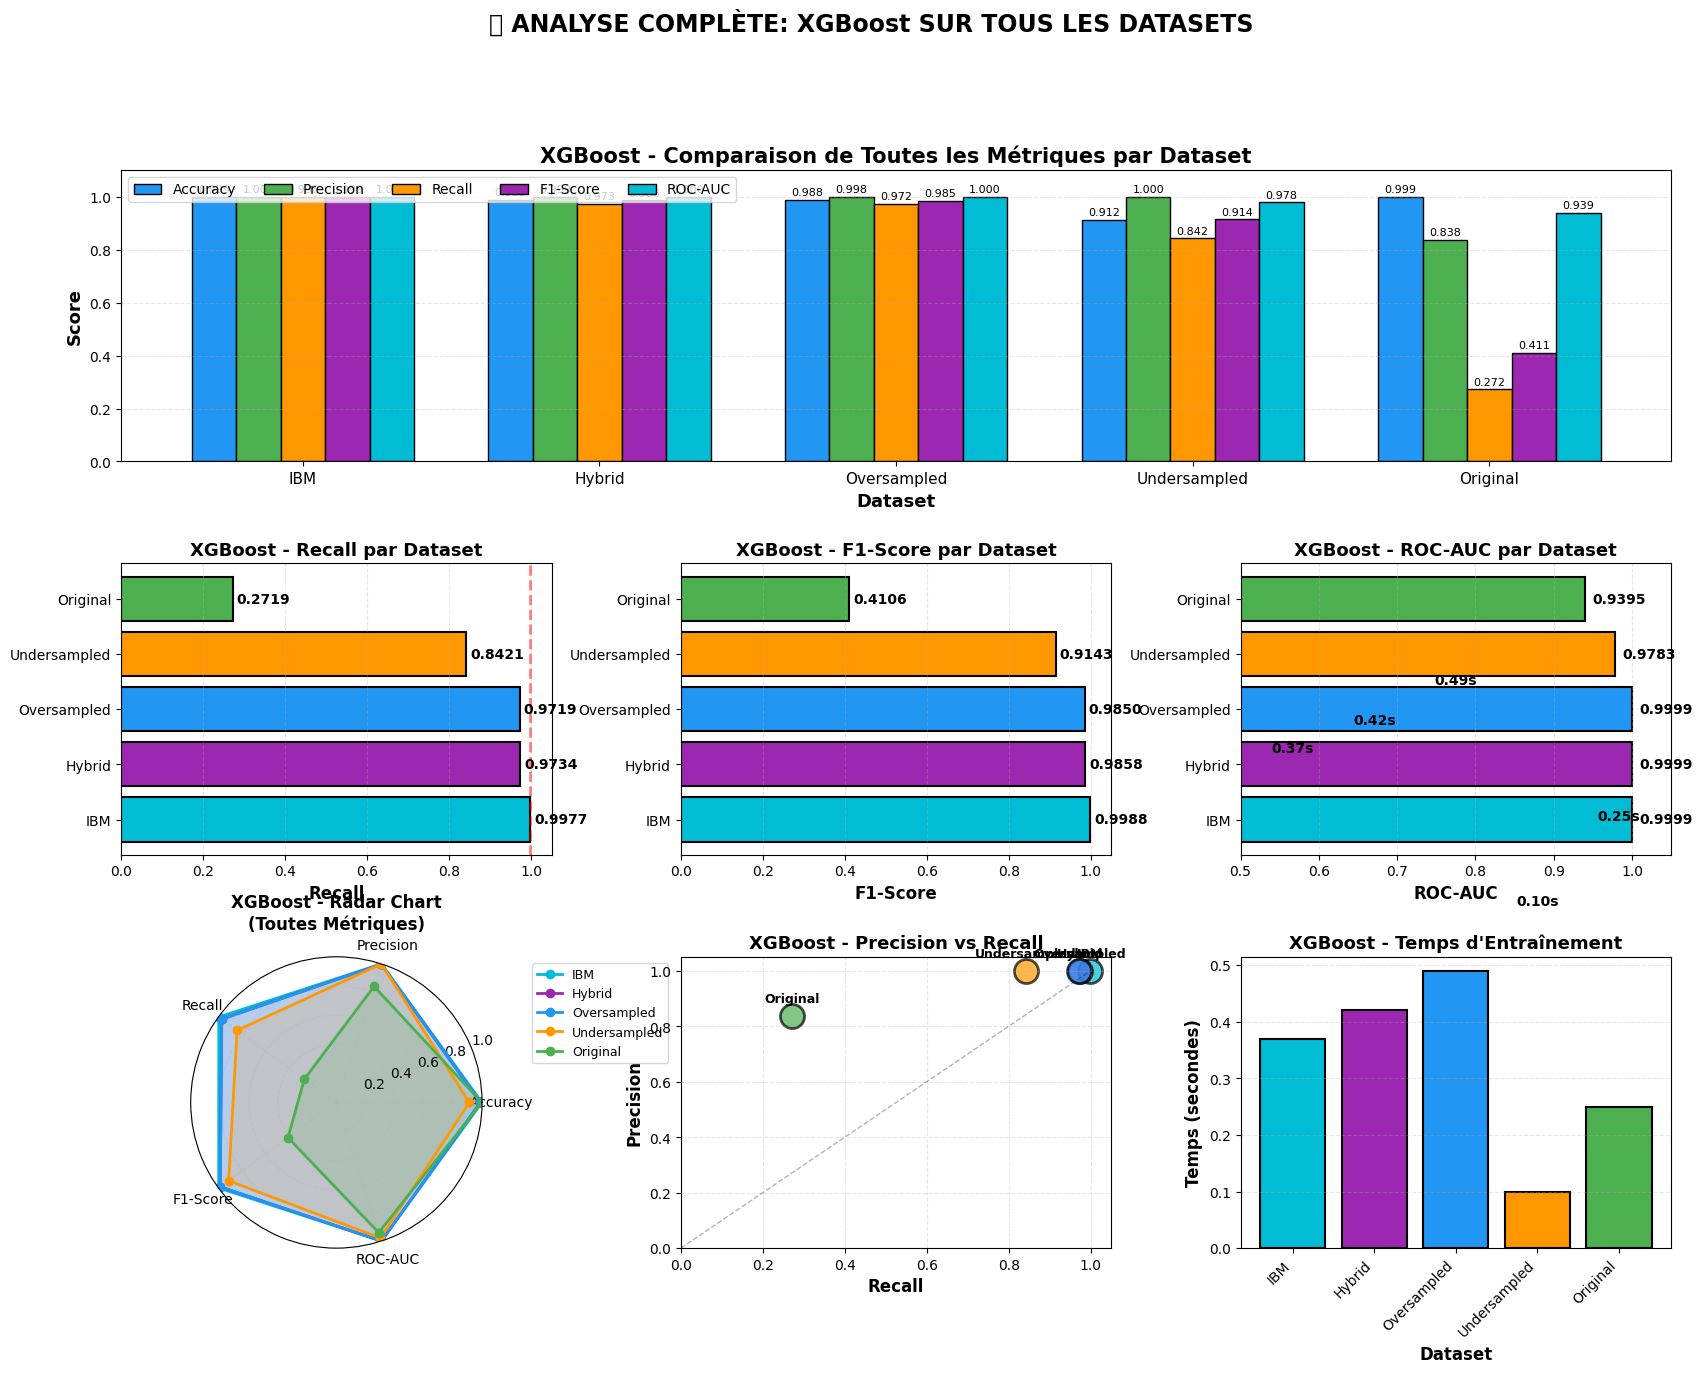


📊 COMPARAISON: XGBoost vs Autres Modèles (sur meilleur dataset)

Dataset sélectionné: IBM

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Train Time (s)
            XGBoost  0.999163   0.999974 0.997693  0.998832 0.999930            0.37
      Decision Tree  0.998906   0.999512 0.997437  0.998473 0.998640            0.43
           LightGBM  0.999053   1.000000 0.997360  0.998678 0.999950            0.61
      Random Forest  0.998970   1.000000 0.997129  0.998563 0.999950            2.65
Logistic Regression  0.663042   0.551221 0.325217  0.409079 0.635451            7.14

🏆 XGBoost se classe #1 sur 5 modèles pour le dataset 'IBM'

✅ Analyse approfondie de XGBoost terminée!


In [252]:
# ==================================================================================
# 🔍 ANALYSE APPROFONDIE: XGBoost
# ==================================================================================

print("="*80)
print("🚀 ANALYSE DÉTAILLÉE DU MODÈLE XGBoost SUR TOUS LES DATASETS")
print("="*80 + "\n")

# Filtrer les données pour XGBoost uniquement
xgboost_data = df_results[df_results['Model'] == 'XGBoost'].copy()

if xgboost_data.empty:
    print("❌ Aucune donnée trouvée pour XGBoost.")
else:
    # Trier par Recall décroissant
    xgboost_data = xgboost_data.sort_values('Recall', ascending=False)
    
    # ==================================================================================
    # 1. TABLEAU RÉCAPITULATIF XGBoost
    # ==================================================================================
    print("📋 PERFORMANCES DE XGBoost PAR DATASET:\n")
    display_cols = ['Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Train Time (s)']
    print(xgboost_data[display_cols].to_string(index=False))
    
    # Meilleur et pire dataset
    best_dataset = xgboost_data.iloc[0]
    worst_dataset = xgboost_data.iloc[-1]
    
    print("\n" + "="*80)
    print(f"🏆 MEILLEUR DATASET: {best_dataset['Dataset']}")
    print("="*80)
    print(f"  • Recall: {best_dataset['Recall']:.4f}")
    print(f"  • F1-Score: {best_dataset['F1-Score']:.4f}")
    print(f"  • ROC-AUC: {best_dataset['ROC-AUC']:.4f}")
    print(f"  • Precision: {best_dataset['Precision']:.4f}")
    print(f"  • Temps d'entraînement: {best_dataset['Train Time (s)']:.2f}s")
    
    print("\n" + "="*80)
    print(f"📉 DATASET LE MOINS PERFORMANT: {worst_dataset['Dataset']}")
    print("="*80)
    print(f"  • Recall: {worst_dataset['Recall']:.4f}")
    print(f"  • F1-Score: {worst_dataset['F1-Score']:.4f}")
    print(f"  • ROC-AUC: {worst_dataset['ROC-AUC']:.4f}")
    print(f"  • Precision: {worst_dataset['Precision']:.4f}")
    print(f"  • Temps d'entraînement: {worst_dataset['Train Time (s)']:.2f}s")
    
    # ==================================================================================
    # 2. VISUALISATIONS DÉTAILLÉES
    # ==================================================================================
    print("\n" + "="*80)
    print("📊 GÉNÉRATION DES VISUALISATIONS DÉTAILLÉES POUR XGBoost")
    print("="*80 + "\n")
    
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    
    # Couleurs pour les datasets
    dataset_colors_xgb = {
        'Original': '#4CAF50',
        'Undersampled': '#FF9800',
        'Oversampled': '#2196F3',
        'Hybrid': '#9C27B0',
        'IBM': '#00BCD4'
    }
    
    colors_bars = [dataset_colors_xgb.get(ds, 'gray') for ds in xgboost_data['Dataset']]
    
    # ==================================================================================
    # GRAPHIQUE 1: Comparaison de toutes les métriques (Bar Chart)
    # ==================================================================================
    ax1 = fig.add_subplot(gs[0, :])
    
    datasets_list = xgboost_data['Dataset'].tolist()
    x = np.arange(len(datasets_list))
    width = 0.15
    
    metrics_to_compare = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    colors_metrics = ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0', '#00BCD4']
    
    for i, metric in enumerate(metrics_to_compare):
        values = xgboost_data[metric].tolist()
        bars = ax1.bar(x + i * width - 2*width, values, width, 
                      label=metric, color=colors_metrics[i], 
                      edgecolor='black', linewidth=1)
        
        # Ajouter les valeurs sur les barres
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=8)
    
    ax1.set_xlabel('Dataset', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=13, fontweight='bold')
    ax1.set_title('XGBoost - Comparaison de Toutes les Métriques par Dataset', 
                 fontsize=15, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets_list, rotation=0, fontsize=11)
    ax1.legend(loc='upper left', ncol=5, fontsize=10)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_ylim([0, 1.1])
    
    # ==================================================================================
    # GRAPHIQUE 2: Recall par Dataset (Bar Chart avec gradient)
    # ==================================================================================
    ax2 = fig.add_subplot(gs[1, 0])
    
    bars = ax2.barh(xgboost_data['Dataset'], xgboost_data['Recall'], 
                    color=colors_bars, edgecolor='black', linewidth=1.5)
    
    # Ajouter les valeurs
    for i, (bar, val) in enumerate(zip(bars, xgboost_data['Recall'])):
        ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.4f}', va='center', fontweight='bold', fontsize=10)
    
    ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax2.set_title('XGBoost - Recall par Dataset', fontsize=13, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.set_xlim([0, 1.05])
    
    # Ligne de référence pour le meilleur
    ax2.axvline(xgboost_data['Recall'].max(), color='red', 
               linestyle='--', linewidth=2, alpha=0.5)
    
    # ==================================================================================
    # GRAPHIQUE 3: F1-Score par Dataset
    # ==================================================================================
    ax3 = fig.add_subplot(gs[1, 1])
    
    bars = ax3.barh(xgboost_data['Dataset'], xgboost_data['F1-Score'], 
                    color=colors_bars, edgecolor='black', linewidth=1.5)
    
    for i, (bar, val) in enumerate(zip(bars, xgboost_data['F1-Score'])):
        ax3.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.4f}', va='center', fontweight='bold', fontsize=10)
    
    ax3.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
    ax3.set_title('XGBoost - F1-Score par Dataset', fontsize=13, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3, linestyle='--')
    ax3.set_xlim([0, 1.05])
    
    # ==================================================================================
    # GRAPHIQUE 4: ROC-AUC par Dataset
    # ==================================================================================
    ax4 = fig.add_subplot(gs[1, 2])
    
    bars = ax4.barh(xgboost_data['Dataset'], xgboost_data['ROC-AUC'], 
                    color=colors_bars, edgecolor='black', linewidth=1.5)
    
    for i, (bar, val) in enumerate(zip(bars, xgboost_data['ROC-AUC'])):
        ax4.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.4f}', va='center', fontweight='bold', fontsize=10)
    
    ax4.set_xlabel('ROC-AUC', fontsize=12, fontweight='bold')
    ax4.set_title('XGBoost - ROC-AUC par Dataset', fontsize=13, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3, linestyle='--')
    ax4.set_xlim([0.5, 1.05])
    
    # ==================================================================================
    # GRAPHIQUE 5: Radar Chart - Vue d'ensemble des métriques
    # ==================================================================================
    ax5 = fig.add_subplot(gs[2, 0], projection='polar')
    
    metrics_radar = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    num_vars = len(metrics_radar)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    for idx, row in xgboost_data.iterrows():
        values = [row[metric] for metric in metrics_radar]
        values += values[:1]
        
        color = dataset_colors_xgb.get(row['Dataset'], 'gray')
        ax5.plot(angles, values, 'o-', linewidth=2, label=row['Dataset'], color=color)
        ax5.fill(angles, values, alpha=0.15, color=color)
    
    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(metrics_radar, fontsize=10)
    ax5.set_ylim(0, 1)
    ax5.set_title('XGBoost - Radar Chart\n(Toutes Métriques)', 
                 fontsize=12, fontweight='bold', pad=20)
    ax5.legend(loc='upper left', bbox_to_anchor=(1.15, 1.0), fontsize=9)
    ax5.grid(True, linestyle='--', alpha=0.3)
    
    # ==================================================================================
    # GRAPHIQUE 6: Precision vs Recall (Scatter Plot)
    # ==================================================================================
    ax6 = fig.add_subplot(gs[2, 1])
    
    for idx, row in xgboost_data.iterrows():
        color = dataset_colors_xgb.get(row['Dataset'], 'gray')
        ax6.scatter(row['Recall'], row['Precision'], 
                   s=300, alpha=0.7, color=color,
                   edgecolors='black', linewidth=2)
        ax6.annotate(row['Dataset'], 
                    (row['Recall'], row['Precision']),
                    textcoords="offset points", xytext=(0,10),
                    ha='center', fontsize=9, fontweight='bold')
    
    ax6.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax6.set_title('XGBoost - Precision vs Recall', fontsize=13, fontweight='bold')
    ax6.grid(True, alpha=0.3, linestyle='--')
    ax6.set_xlim([0, 1.05])
    ax6.set_ylim([0, 1.05])
    ax6.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
    
    # ==================================================================================
    # GRAPHIQUE 7: Temps d'entraînement par Dataset
    # ==================================================================================
    ax7 = fig.add_subplot(gs[2, 2])
    
    bars = ax7.bar(xgboost_data['Dataset'], xgboost_data['Train Time (s)'], 
                   color=colors_bars, edgecolor='black', linewidth=1.5)
    
    for bar, val in zip(bars, xgboost_data['Train Time (s)']):
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{val:.2f}s', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)
    
    ax7.set_ylabel('Temps (secondes)', fontsize=12, fontweight='bold')
    ax7.set_xlabel('Dataset', fontsize=12, fontweight='bold')
    ax7.set_title('XGBoost - Temps d\'Entraînement', fontsize=13, fontweight='bold')
    ax7.grid(axis='y', alpha=0.3, linestyle='--')
    ax7.set_xticklabels(ax7.get_xticklabels(), rotation=45, ha='right')
    
    plt.suptitle('🚀 ANALYSE COMPLÈTE: XGBoost SUR TOUS LES DATASETS', 
                fontsize=17, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()
    
    # ==================================================================================
    # 3. ANALYSE COMPARATIVE AVEC AUTRES MODÈLES
    # ==================================================================================
    print("\n" + "="*80)
    print("📊 COMPARAISON: XGBoost vs Autres Modèles (sur meilleur dataset)")
    print("="*80 + "\n")
    
    best_xgb_dataset = best_dataset['Dataset']
    all_models_on_best = df_results[df_results['Dataset'] == best_xgb_dataset].copy()
    all_models_on_best = all_models_on_best.sort_values('Recall', ascending=False)
    
    print(f"Dataset sélectionné: {best_xgb_dataset}\n")
    print(all_models_on_best[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Train Time (s)']].to_string(index=False))
    
    # Position de XGBoost dans le classement
    xgb_position = all_models_on_best[all_models_on_best['Model'] == 'XGBoost'].index[0]
    xgb_rank = all_models_on_best.index.get_loc(xgb_position) + 1
    
    print(f"\n🏆 XGBoost se classe #{xgb_rank} sur {len(all_models_on_best)} modèles pour le dataset '{best_xgb_dataset}'")
    
    print("\n✅ Analyse approfondie de XGBoost terminée!")
    print("="*80)